# Rossmann Store Sales Forecast:


Rossmann is a leading European pharmaceutical retailer, operating over 3,000 stores across seven countries. Given the short shelf life of many products, it is critical for Rossmann to forecast sales accurately at each store location. Currently, store managers are responsible for predicting daily sales for the upcoming six weeks.

Store sales are influenced by various factors, such as promotional activities, competition, public holidays, seasonality, and the specific characteristics of each location.

With thousands of managers relying on their individual experiences and intuitions, forecast accuracy tends to vary significantly. To address this challenge, Rossmann has brought you on board as a data scientist to develop a more robust forecasting model. Your task is to build a model that predicts daily sales for the next six weeks, using historical sales data from 1,115 Rossmann stores.

## Step 1. Importing all the important libraries

In [ ]:
# Importing important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from pylab import rcParams
rcParams["figure.figsize"] = 18, 14

# Importing stationarity tests

from statsmodels.tsa.stattools import adfuller, kpss

# Importing ACF and PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing MinMaxScaler()

from sklearn.preprocessing import MinMaxScaler

# Importing MeanSquaredError()

from sklearn.metrics import mean_squared_error

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/upgrad_app/forecast/capstone_project/'

In [ ]:
# Changing settings to see maximum data

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("max_colwidth", None)

In [ ]:
# Importing Models

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

## Step 2. Reading the Datasets and Initial Understanding

In [ ]:
# Train Dataset
df_raw_train = pd.read_csv(filepath + 'train.csv')

# Store Dataset
df_raw_store = pd.read_csv(filepath + 'store.csv')

In [ ]:
# Displaying Train Dataset

df_raw_train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      1          5  2015-07-31   5263        555     1      1            0              1
1      2          5  2015-07-31   6064        625     1      1            0              1
2      3          5  2015-07-31   8314        821     1      1            0              1
3      4          5  2015-07-31  13995       1498     1      1            0              1
4      5          5  2015-07-31   4822        559     1      1            0              1

In [ ]:
# Checking the shape of Train Dataset

df_raw_train.shape

(1017209, 9)

In [ ]:
# Displaying Store Dataset

df_raw_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      1         c          a               1270.0                        9.0                    2008.0       0              NaN              NaN              NaN
1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      4         c          c                620.0                        9.0                    2009.0       0              NaN              NaN              NaN
4      5         a          a              29910.0                        4.0                    2015.0       0              NaN              NaN              NaN

In [ ]:
# Checking the shape of Store Dataset

df_raw_store.shape

(1115, 10)

In [ ]:
# Checking the datatype of the columns in the Store dataset

df_raw_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
# Checking the summary of the "Store" dataset

df_raw_store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear
count  1115.00000          1112.000000                 761.000000                761.000000  1115.000000       571.000000       571.000000
mean    558.00000          5404.901079                   7.224704               2008.668857     0.512108        23.595447      2011.763573
std     322.01708          7663.174720                   3.212348                  6.195983     0.500078        14.141984         1.674935
min       1.00000            20.000000                   1.000000               1900.000000     0.000000         1.000000      2009.000000
25%     279.50000           717.500000                   4.000000               2006.000000     0.000000        13.000000      2011.000000
50%     558.00000          2325.000000                   8.000000               2010.000000     1.000000        22.000000      2012.000000
75%     836.50000          6882.500000                  10.000000               2013.000000     1.000000        37.000000      2013.000000
max    1115.00000         75860.000000                  12.000000               2015.000000     1.000000        50.000000      2015.000000

#### *Inference: The columns "CompetitionDistance" and "Promo2SinceWeek" have a significant difference between 75% and maximum value indicating presence of outliers.*

In [ ]:
# Checking the summary of the "Train" dataset

df_raw_train.describe()

Store     DayOfWeek         Sales     Customers          Open         Promo  SchoolHoliday
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00

## Step 3: Dataset Cleaning and Dataset Transformation before EDA

In [ ]:
# Checking percentage of missing/null values

round(100*(df_raw_store.isnull().sum()/len(df_raw_store)),2)

Store                         0.00
StoreType                     0.00
Assortment                    0.00
CompetitionDistance           0.27
CompetitionOpenSinceMonth    31.75
CompetitionOpenSinceYear     31.75
Promo2                        0.00
Promo2SinceWeek              48.79
Promo2SinceYear              48.79
PromoInterval                48.79
dtype: float64

In [ ]:
# Creating a copy for transformations

df_store_transformed = df_raw_store.copy()

In [ ]:
df_store_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
# Replacing "NaN" values for certain columns by 0
# List of Columns to fill "NaN" values with 0

na_to_zero_col_list = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "CompetitionDistance"]

# Fill columns having "NaN" values with 0

df_store_transformed[na_to_zero_col_list] = df_store_transformed[na_to_zero_col_list].fillna(0)

In [ ]:
# Replacing "NaN" values for certain columns by Mode()

na_to_mode_col_list = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

# Fill columns having "NaN" values with Mode()

df_store_transformed[na_to_mode_col_list] = df_store_transformed[na_to_mode_col_list].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [ ]:
df_store_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
# Checking records where "CompetitionDistance" = 0

df_store_transformed[df_store_transformed["CompetitionDistance"]==0]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
290    291         d          a                  0.0                        9.0                    2013.0       0              0.0              0.0                0
621    622         a          c                  0.0                        9.0                    2013.0       0              0.0              0.0                0
878    879         d          a                  0.0                        9.0                    2013.0       1              5.0           2013.0  Feb,May,Aug,Nov

In [ ]:
# Data Discrepancy: If "CompetitionDistance" = 0, it means that there is no competition.
# Hence, the corresponding values of "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" should be zero as well.

df_store_transformed.loc[df_store_transformed.CompetitionDistance == 0, "CompetitionOpenSinceMonth"] = 0
df_store_transformed.loc[df_store_transformed.CompetitionDistance == 0, "CompetitionOpenSinceYear"] = 0

In [ ]:
# Checking records where "CompetitionDistance" = 0
# Data discrepancies have ben fixed

df_store_transformed[df_store_transformed["CompetitionDistance"]==0]

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
290    291         d          a                  0.0                        0.0                       0.0       0              0.0              0.0                0
621    622         a          c                  0.0                        0.0                       0.0       0              0.0              0.0                0
878    879         d          a                  0.0                        0.0                       0.0       1              5.0           2013.0  Feb,May,Aug,Nov

In [ ]:
# Checking percentage of missing/null values

round(100*(df_store_transformed.isnull().sum()/len(df_store_transformed)),2)

Store                        0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

#### *Inference: Null values have been handled successfully!*

## Step 4: Data Visualization and EDA

### (i) Univariate Analysis

In [ ]:
# Creating a UDF for showing the "Countplot()" of the "Categorical Columns"

def countplot_categ_cols(features, df):

    tick_to_ignore = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek"]
    num_features = len(features)
    cols = 2
    rows = (num_features + cols - 1) // cols

    plt.figure(figsize=(16, rows * 5))

    for i, feature in enumerate(features, start=1):
        plt.subplot(rows, cols, i)
        ax = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index)
        plt.xticks(rotation=90)
        plt.title("Counts for {}".format(feature))

        if feature not in tick_to_ignore:
            for p in ax.patches:
                ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 3, "{:.2f}%".format(p.get_height() / len(df) * 100), ha="center")

    plt.tight_layout(pad=5, w_pad=5)
    plt.show()


In [ ]:
# Selecting the "Categorical Columns" from the "Store" dataset

categ_cols_store = ["StoreType","Assortment","CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2",
                    "Promo2SinceWeek","Promo2SinceYear","PromoInterval"]

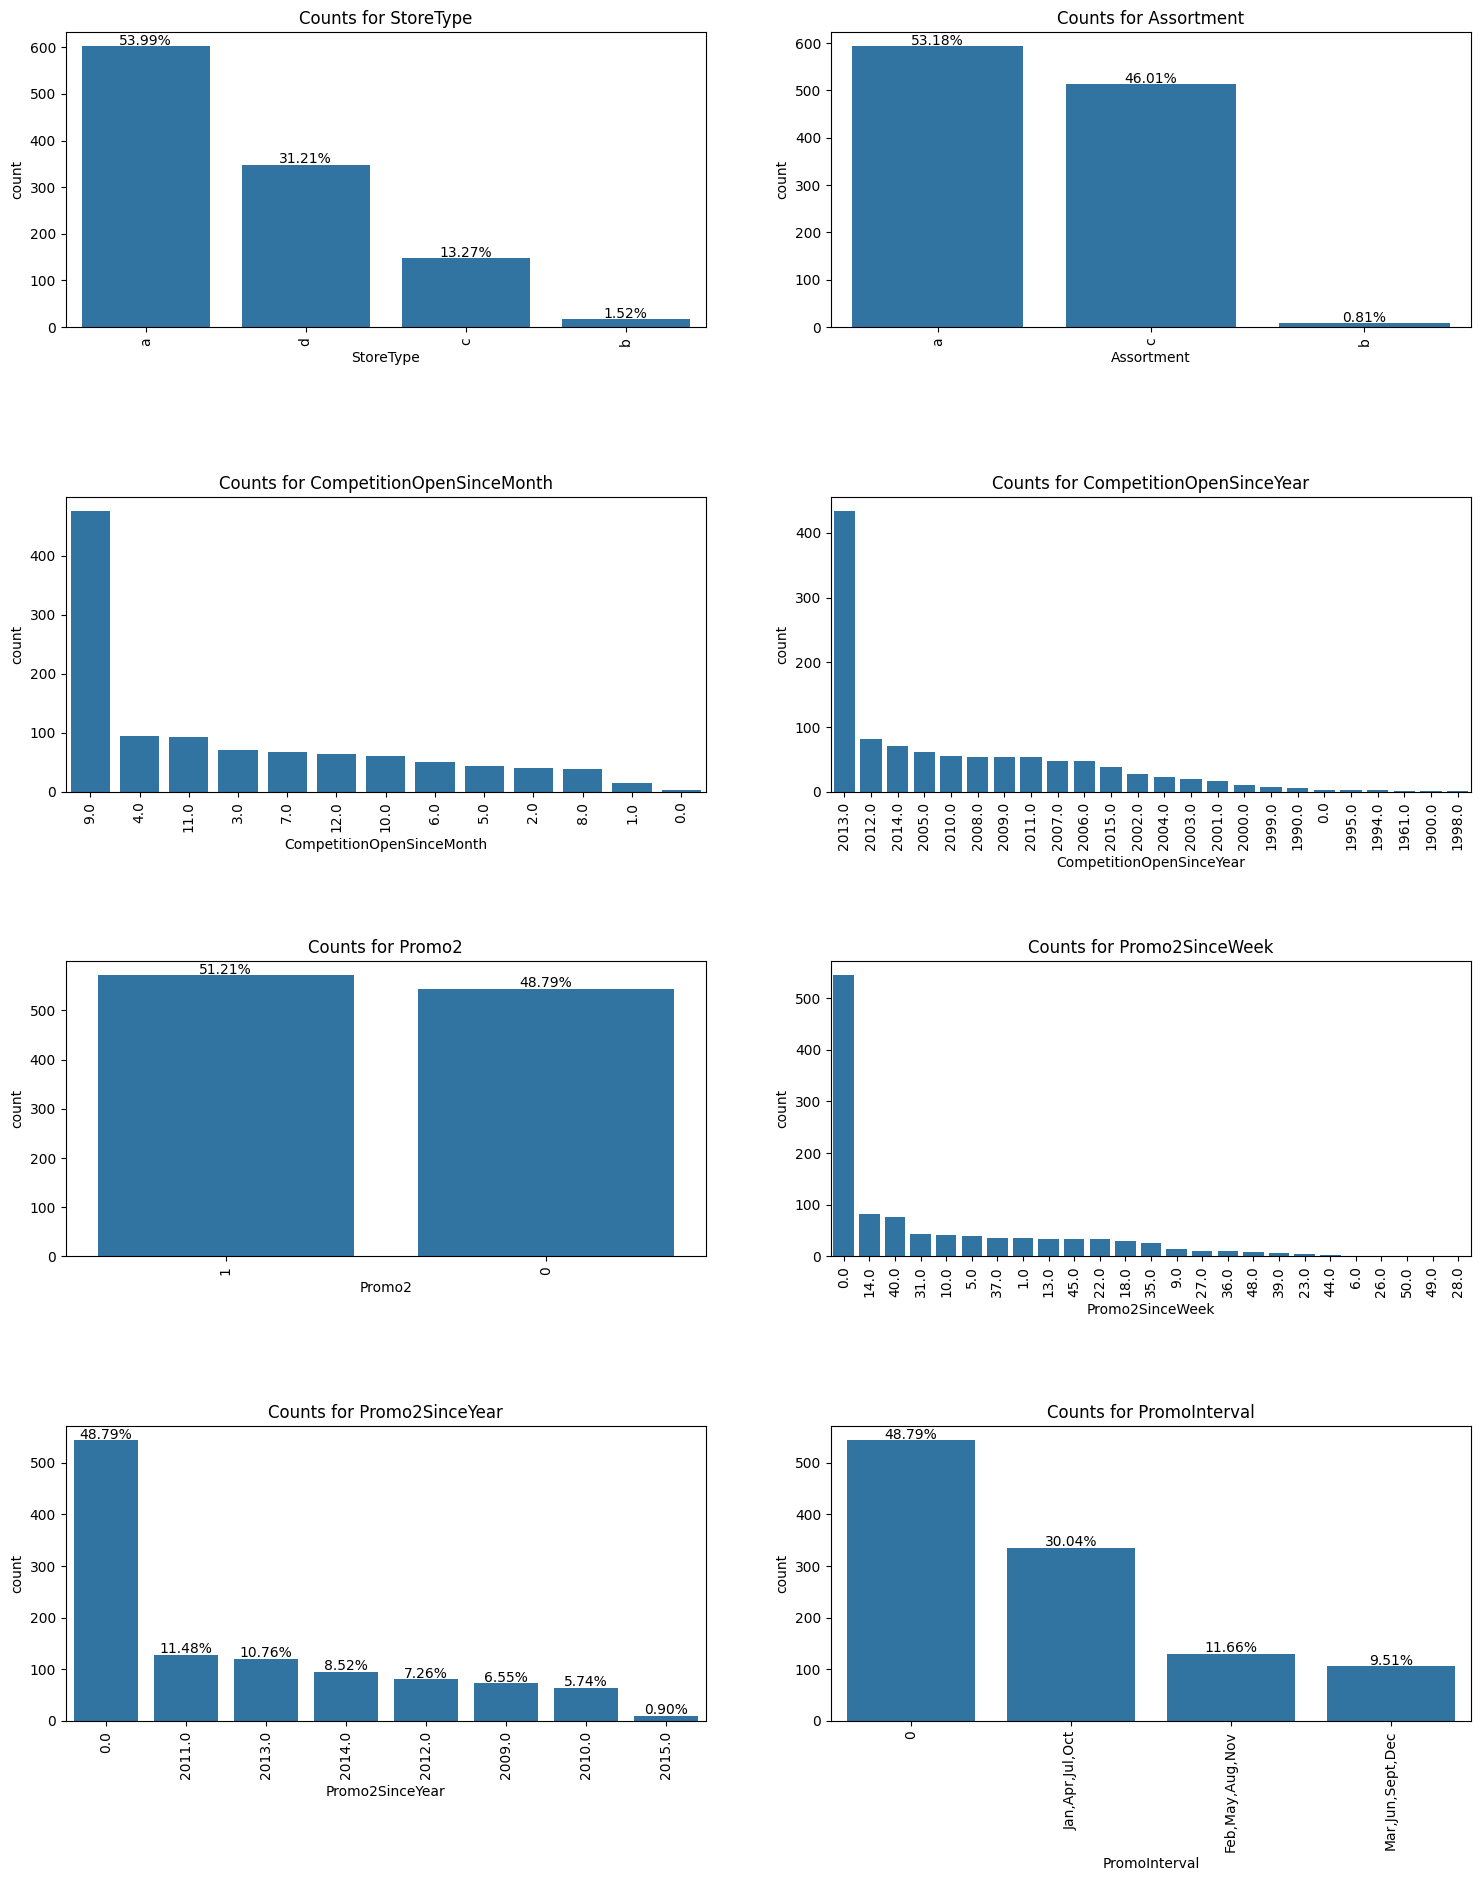

In [ ]:
# Countplots for "Categorical Columns" of "Store" dataset

countplot_categ_cols(categ_cols_store, df_store_transformed)

#### Inferences from the graphs of "Store" dataset:

- Majority of the stores(54%) are of type "A"
    
- Most stores primarily offer type A assortments (53%), with other types being less common

- Majority of the competitive stores opened in 2013

- Maximum number of competitve stores opened in the month of September
    
- Nearly 48% of the stores didn"t participate "in "Promo2" promotions

In [ ]:
# Selecting the "Categorical Columns" from the "Train" dataset

categ_cols_train = ["DayOfWeek","Open", "Promo", "StateHoliday", "SchoolHoliday"]

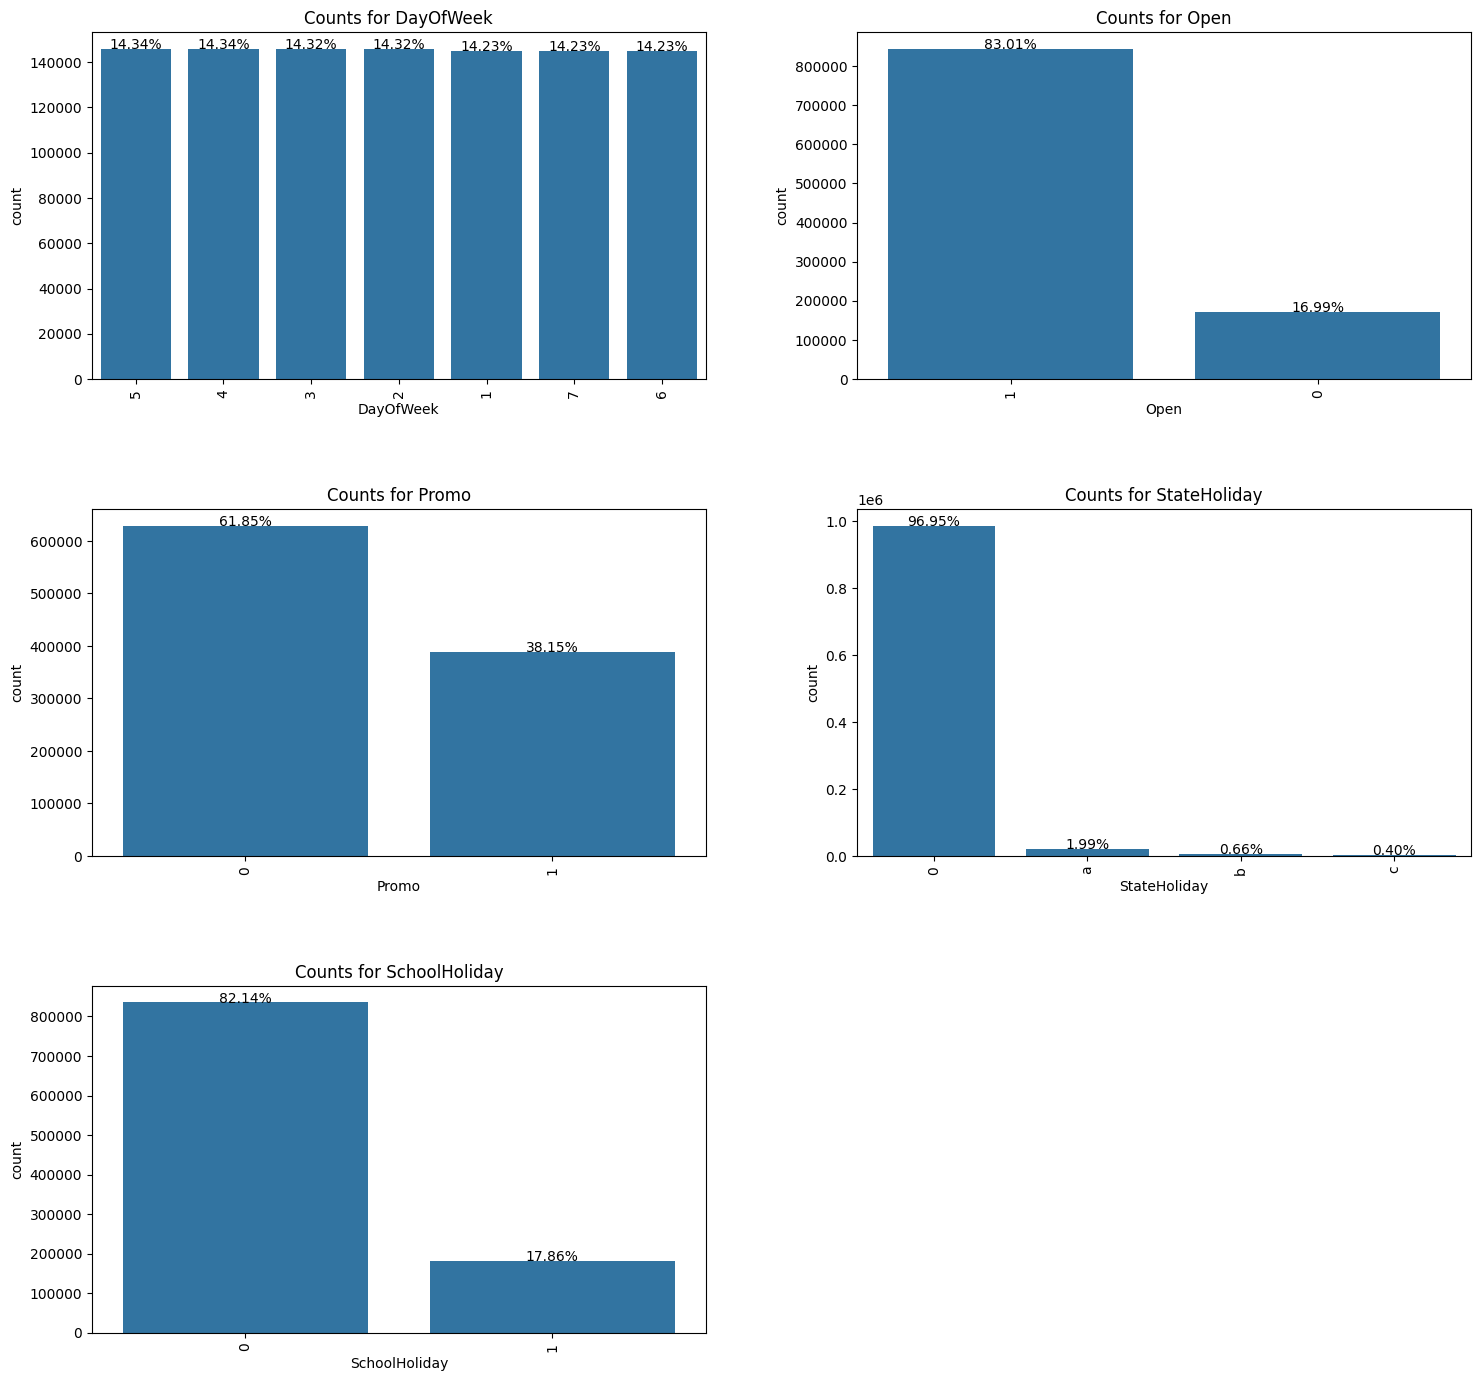

In [ ]:
# Countplots for "Categorical Columns" of "Train" dataset

countplot_categ_cols(categ_cols_train, df_raw_train)

#### Inferences from the graphs of "Train" dataset:

- Sales of a store throughout the week are evenly distributed across all days
    
- Store closures are represented in just 17% of the records

- Active promotions are present in 38% of the records

- 18% of records indicate that the store was affected becauseof "School Holiday"

#### *Callout: We will exclusively examine entries where the store is "open", considering that when the store is closed, sales are naturally zero.*

In [ ]:
# Filtering for "Open" stores of the "Train" dataset

df_train_open = df_raw_train[df_raw_train["Open"] == 1]

In [ ]:
df_train_open.shape

(844392, 9)

### Outlier Detection and Treatment of Outliers

Verifying and mitigating skewed data

#### (a) Handling outliers for "Store" dataset

In [ ]:
# Creating a UDF for plotting the boxplots of a dataset

def plot_boxplots(data, columns):
    num_plots = len(columns)
    cols = 2
    rows = (num_plots + cols - 1) // cols

    plt.figure(figsize=(20, 12))

    for i, column in enumerate(columns, start=1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=column, data=data)

    plt.show()

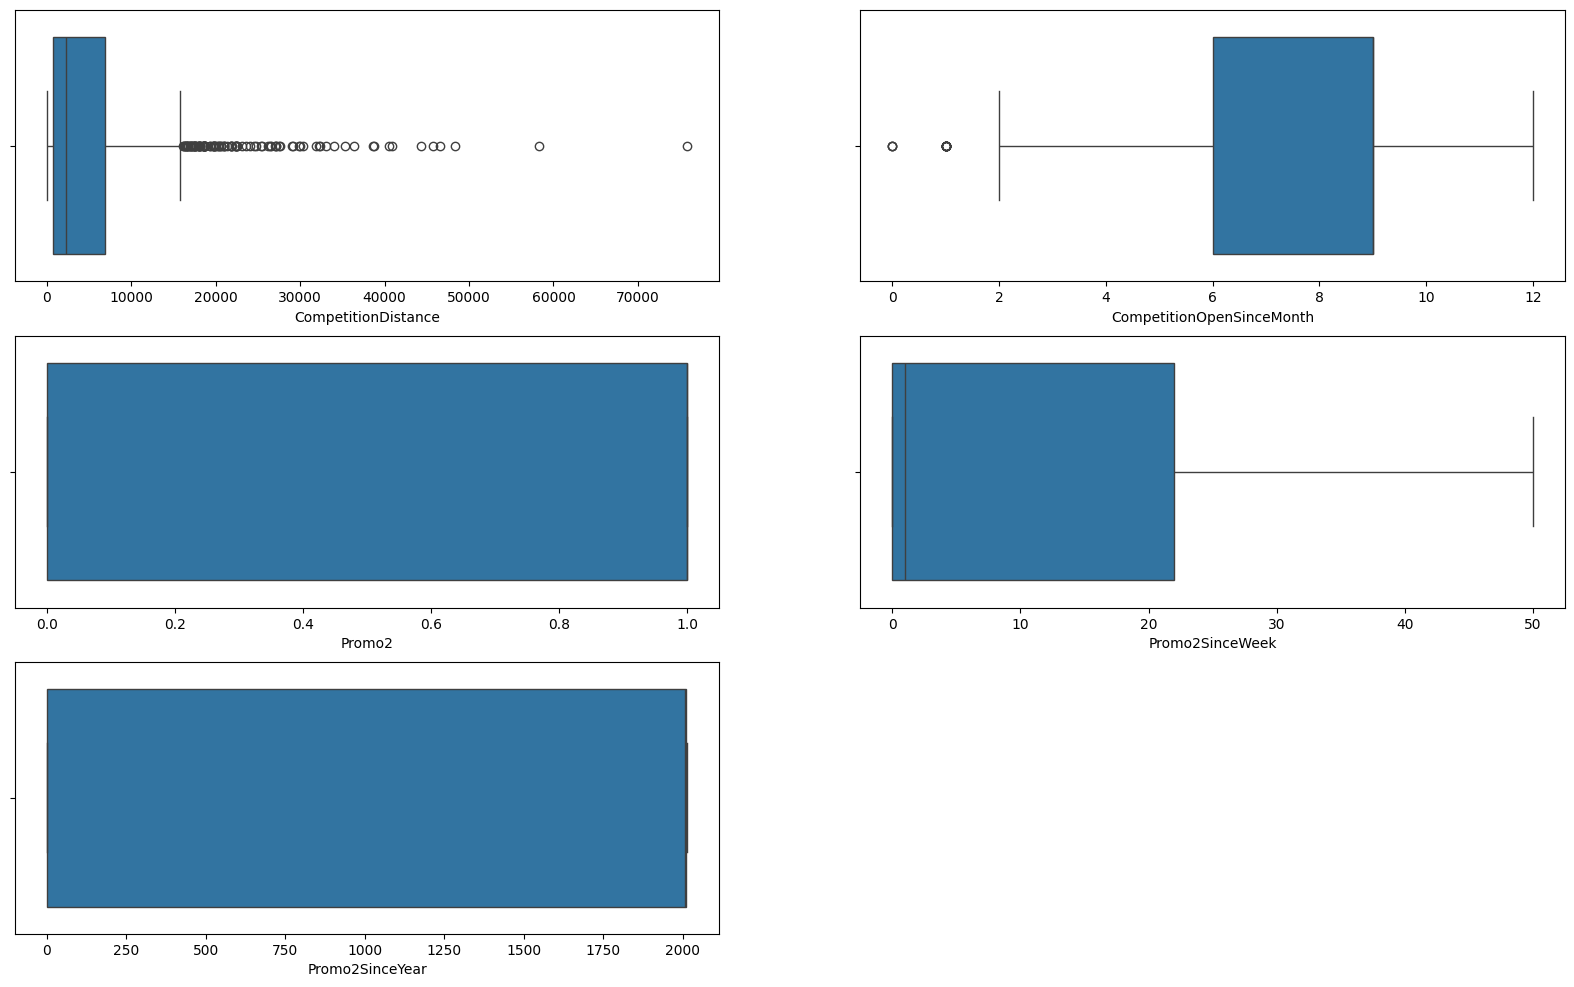

In [ ]:
# Boxlots for "Store" dataset

store_boxplot_cols = ["CompetitionDistance", "CompetitionOpenSinceMonth", "Promo2", "Promo2SinceWeek", "Promo2SinceYear"]

plot_boxplots(df_store_transformed, store_boxplot_cols)

#### *Inference: For "CompetitionDistance", values beyond the 99th percentile are unnecessary. We can set a cap on values exceeding the 99th percentile, limiting them to that percentile in order to manage the "CompetitionDistance" variable.*

In [ ]:
# Capping the values of "CompetitionDistance" to 99th percentile

df_store_transformed.loc[df_store_transformed.CompetitionDistance>df_store_transformed.CompetitionDistance.quantile(.99),"CompetitionDistance"]=df_store_transformed.CompetitionDistance.quantile(.99)

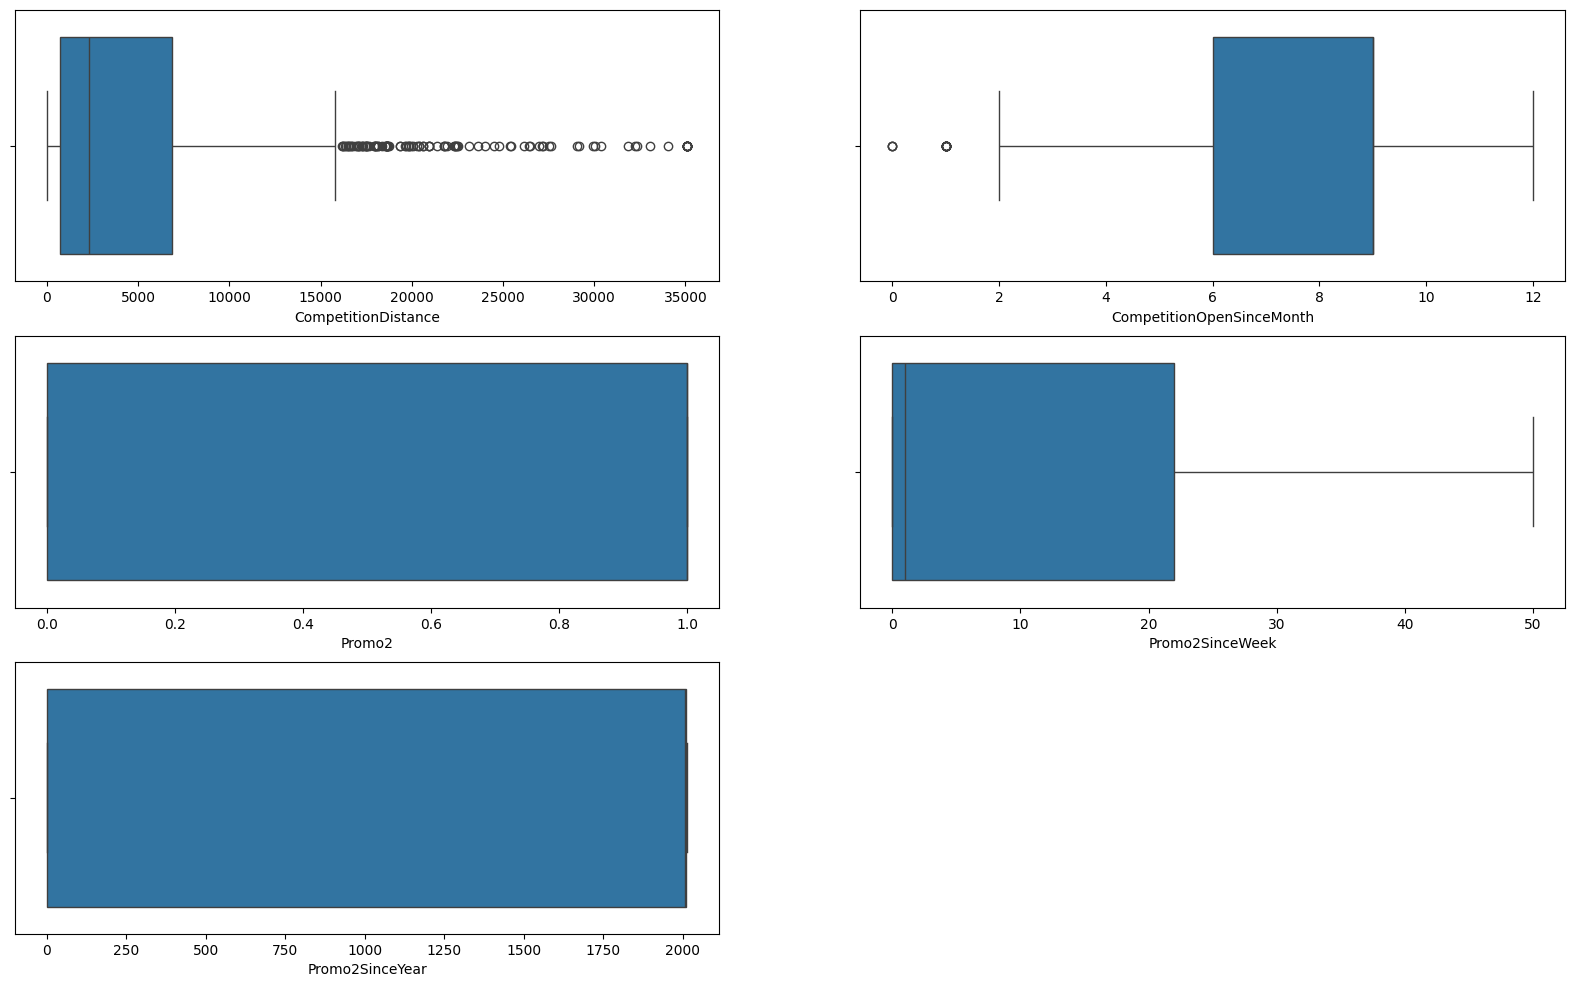

In [ ]:
# Checking the Boxlots for "Store" dataset again after capping the values at 99th percentile

plot_boxplots(df_store_transformed, store_boxplot_cols)

#### *Inference: Outliers for "Store" dataset have been treated.*

#### (b) Handling outliers for "Train" dataset

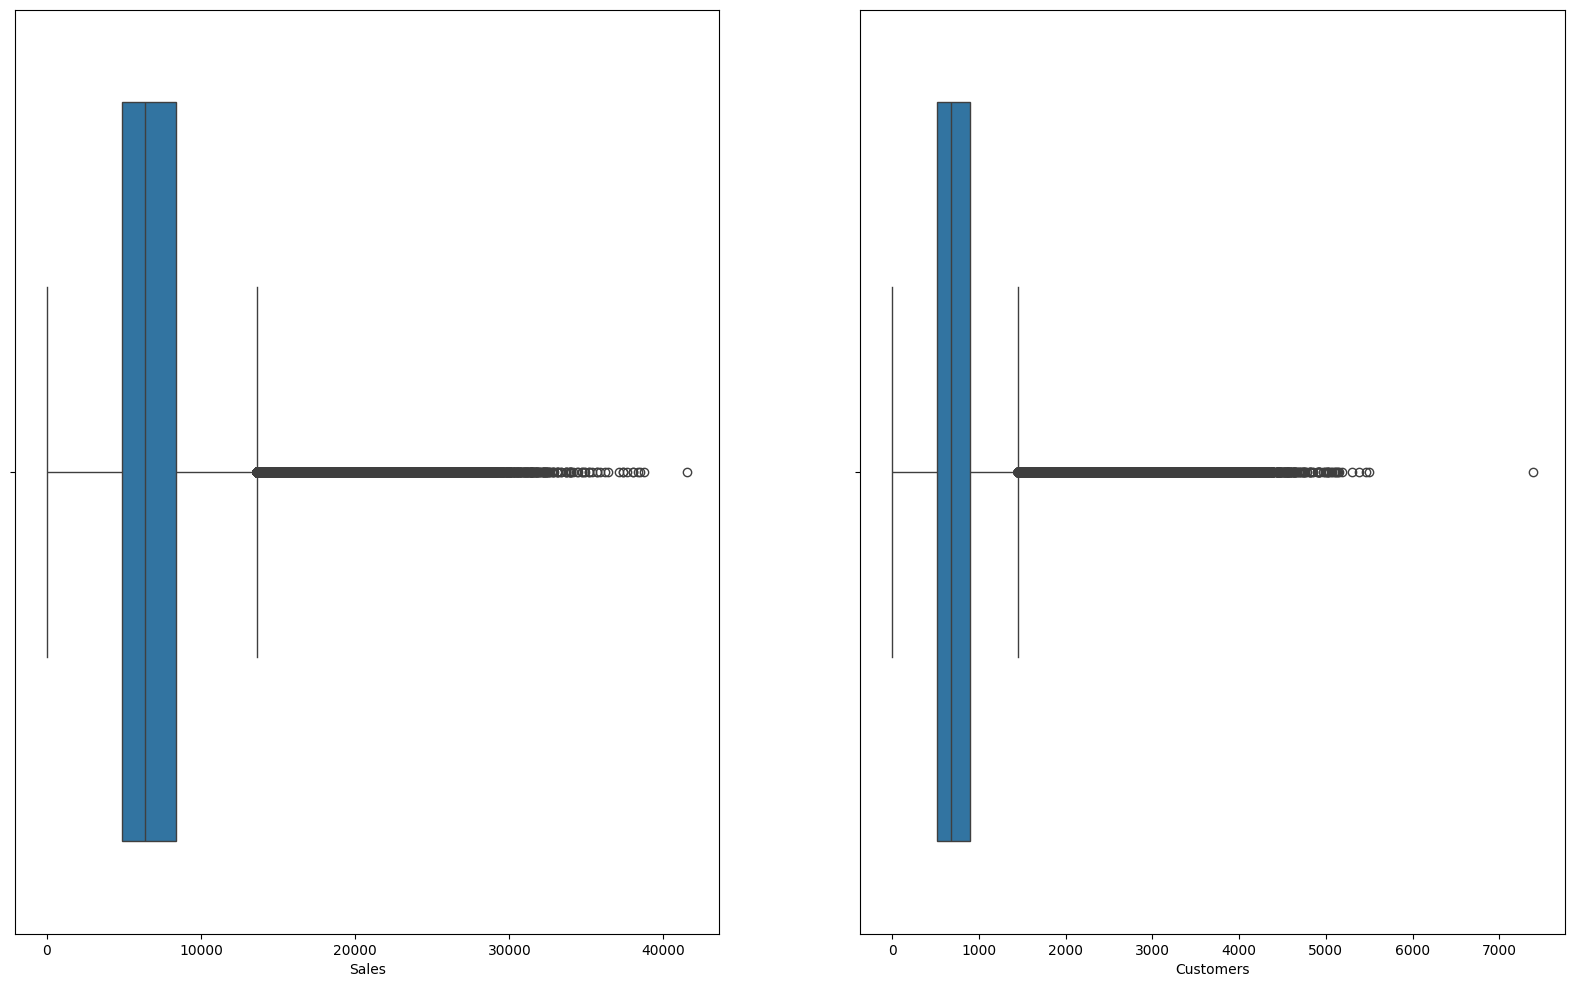

In [ ]:
# Boxlots for "Train" dataset

train_boxplot_cols = ["Sales", "Customers"]

plot_boxplots(df_train_open, train_boxplot_cols)

The data is a right skewed.

In [ ]:
# Detecting outliers at 90, 95 and 99 percentile

df_train_open.describe(percentiles=[0.90,0.95,0.99]).round(2)

Store  DayOfWeek      Sales  Customers      Open      Promo  SchoolHoliday
count  844392.00  844392.00  844392.00  844392.00  844392.0  844392.00      844392.00
mean      558.42       3.52    6955.51     762.73       1.0       0.45           0.19
std       321.73       1.72    3104.21     401.23       0.0       0.50           0.40
min         1.00       1.00       0.00       0.00       1.0       0.00           0.00
50%       558.00       3.00    6369.00     676.00       1.0       0.00           0.00
90%      1004.00       6.00   10771.00    1177.00       1.0       1.00           1.00
95%      1060.00       6.00   12668.00    1440.00       1.0       1.00           1.00
99%      1104.00       6.00   17789.00    2415.00       1.0       1.00           1.00
max      1115.00       7.00   41551.00    7388.00       1.0       1.00           1.00

In [ ]:
# Capping the values of "Sales" to 99th percentile

df_train_sales = df_train_open[~(df_train_open["Sales"] > 17789)]

# Capping the values of "Customers" to 99th percentile

df_train_transformed = df_train_sales[~(df_train_sales["Customers"] > 2415)]

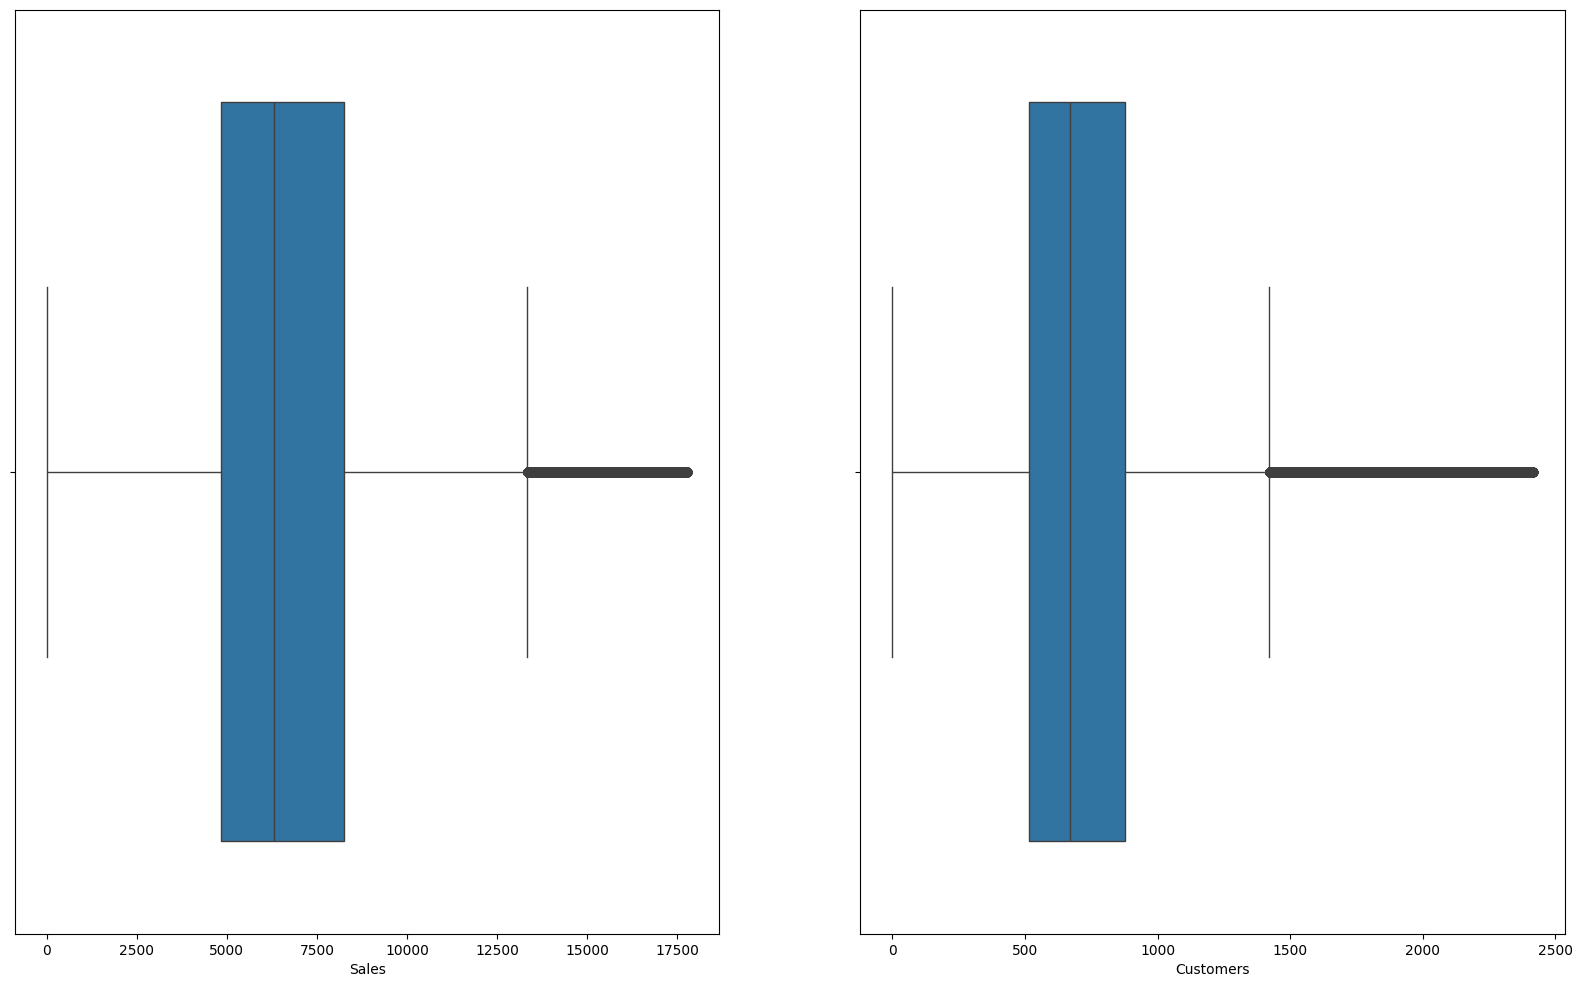

In [ ]:
# Checking the Boxlots for "Train" dataset again after capping the values at 99th percentile

plot_boxplots(df_train_transformed, train_boxplot_cols)

#### *Inference: Outliers for "Train" dataset have been treated.*

In [ ]:
df_store_transformed.shape

(1115, 10)

In [ ]:
df_train_transformed.shape

(831626, 9)

In [ ]:
# Resetting the index for both "Store" and "Train" datasets

# Resetting the index for "Store" dataset
df_store_transformed = df_store_transformed.reset_index()

# Resetting the index for "Train" dataset
df_train_transformed = df_train_transformed.reset_index()

In [ ]:
# Displaying "Store" dataset

df_store_transformed.head()

index  Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval
0      0      1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0                0
1      1      2         a          a                570.0                       11.0                    2007.0       1             13.0           2010.0  Jan,Apr,Jul,Oct
2      2      3         a          a              14130.0                       12.0                    2006.0       1             14.0           2011.0  Jan,Apr,Jul,Oct
3      3      4         c          c                620.0                        9.0                    2009.0       0              0.0              0.0                0
4      4      5         a          a              29910.0                        4.0                    2015.0       0              0.0              0.0                0

In [ ]:
# Checking the shape of the "Store" dataset

df_store_transformed.shape

(1115, 11)

In [ ]:
# Displaying "Train" dataset

df_train_transformed.head()

index  Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday
0      0      1          5  2015-07-31   5263        555     1      1            0              1
1      1      2          5  2015-07-31   6064        625     1      1            0              1
2      2      3          5  2015-07-31   8314        821     1      1            0              1
3      3      4          5  2015-07-31  13995       1498     1      1            0              1
4      4      5          5  2015-07-31   4822        559     1      1            0              1

In [ ]:
# Checking the shape of the "Train" dataset

df_train_transformed.shape

(831626, 10)

#### Merging "Store" and "Train" datasets on "Store" column

In [ ]:
# Merging "Store" and "Train" datasets

df_merged = df_train_transformed.merge(right = df_store_transformed, on = "Store", how = "inner")

In [ ]:
# Removing the "index" columns of "Train" and "Store" datasets

df_merged_transformed = df_merged.drop(["index_x", "index_y"], axis = 1)

In [ ]:
# Displaying "Merged" dataset

df_merged_transformed.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval
0      1          5  2015-07-31   5263        555     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0             0
1      1          4  2015-07-30   5020        546     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0             0
2      1          3  2015-07-29   4782        523     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0             0
3      1          2  2015-07-28   5011        560     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0             0
4      1          1  2015-07-27   6102        612     1      1            0              1         c          a               1270.0                        9.0                    2008.0       0              0.0              0.0             0

In [ ]:
# Checking the shape of "Merged" dataset

df_merged_transformed.shape

(831626, 18)

In [ ]:
# Checking the datatype of the columns of "Merged" dataset

df_merged_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831626 entries, 0 to 831625
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      831626 non-null  int64  
 1   DayOfWeek                  831626 non-null  int64  
 2   Date                       831626 non-null  object 
 3   Sales                      831626 non-null  int64  
 4   Customers                  831626 non-null  int64  
 5   Open                       831626 non-null  int64  
 6   Promo                      831626 non-null  int64  
 7   StateHoliday               831626 non-null  object 
 8   SchoolHoliday              831626 non-null  int64  
 9   StoreType                  831626 non-null  object 
 10  Assortment                 831626 non-null  object 
 11  CompetitionDistance        831626 non-null  float64
 12  CompetitionOpenSinceMonth  831626 non-null  float64
 13  CompetitionOpenSinceYear   83

In [ ]:
# Checking percentage of missing/null values

round(100*(df_merged_transformed.isnull().sum()/len(df_merged_transformed)),2)

Store                        0.0
DayOfWeek                    0.0
Date                         0.0
Sales                        0.0
Customers                    0.0
Open                         0.0
Promo                        0.0
StateHoliday                 0.0
SchoolHoliday                0.0
StoreType                    0.0
Assortment                   0.0
CompetitionDistance          0.0
CompetitionOpenSinceMonth    0.0
CompetitionOpenSinceYear     0.0
Promo2                       0.0
Promo2SinceWeek              0.0
Promo2SinceYear              0.0
PromoInterval                0.0
dtype: float64

#### *Inference: No null values are present in the "Merged" dataset*

### (ii) Bivariate Analysis

In [ ]:
# Creating a UDF to plot the boxplots of various variable w.r.t "Sales" column

def boxplot_bivariate(df, column_list):

    num_attributes = len(column_list)
    num_rows = (num_attributes - 1) // 3 + 1
    num_cols = min(num_attributes, 3)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6*num_rows))

    axes = axes.flatten()

    for i, attribute in enumerate(column_list):
        sns.boxplot(x=attribute, y="Sales", data=df, ax=axes[i])
        axes[i].set_title(f"Sales vs {attribute}")

    for j in range(num_attributes, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

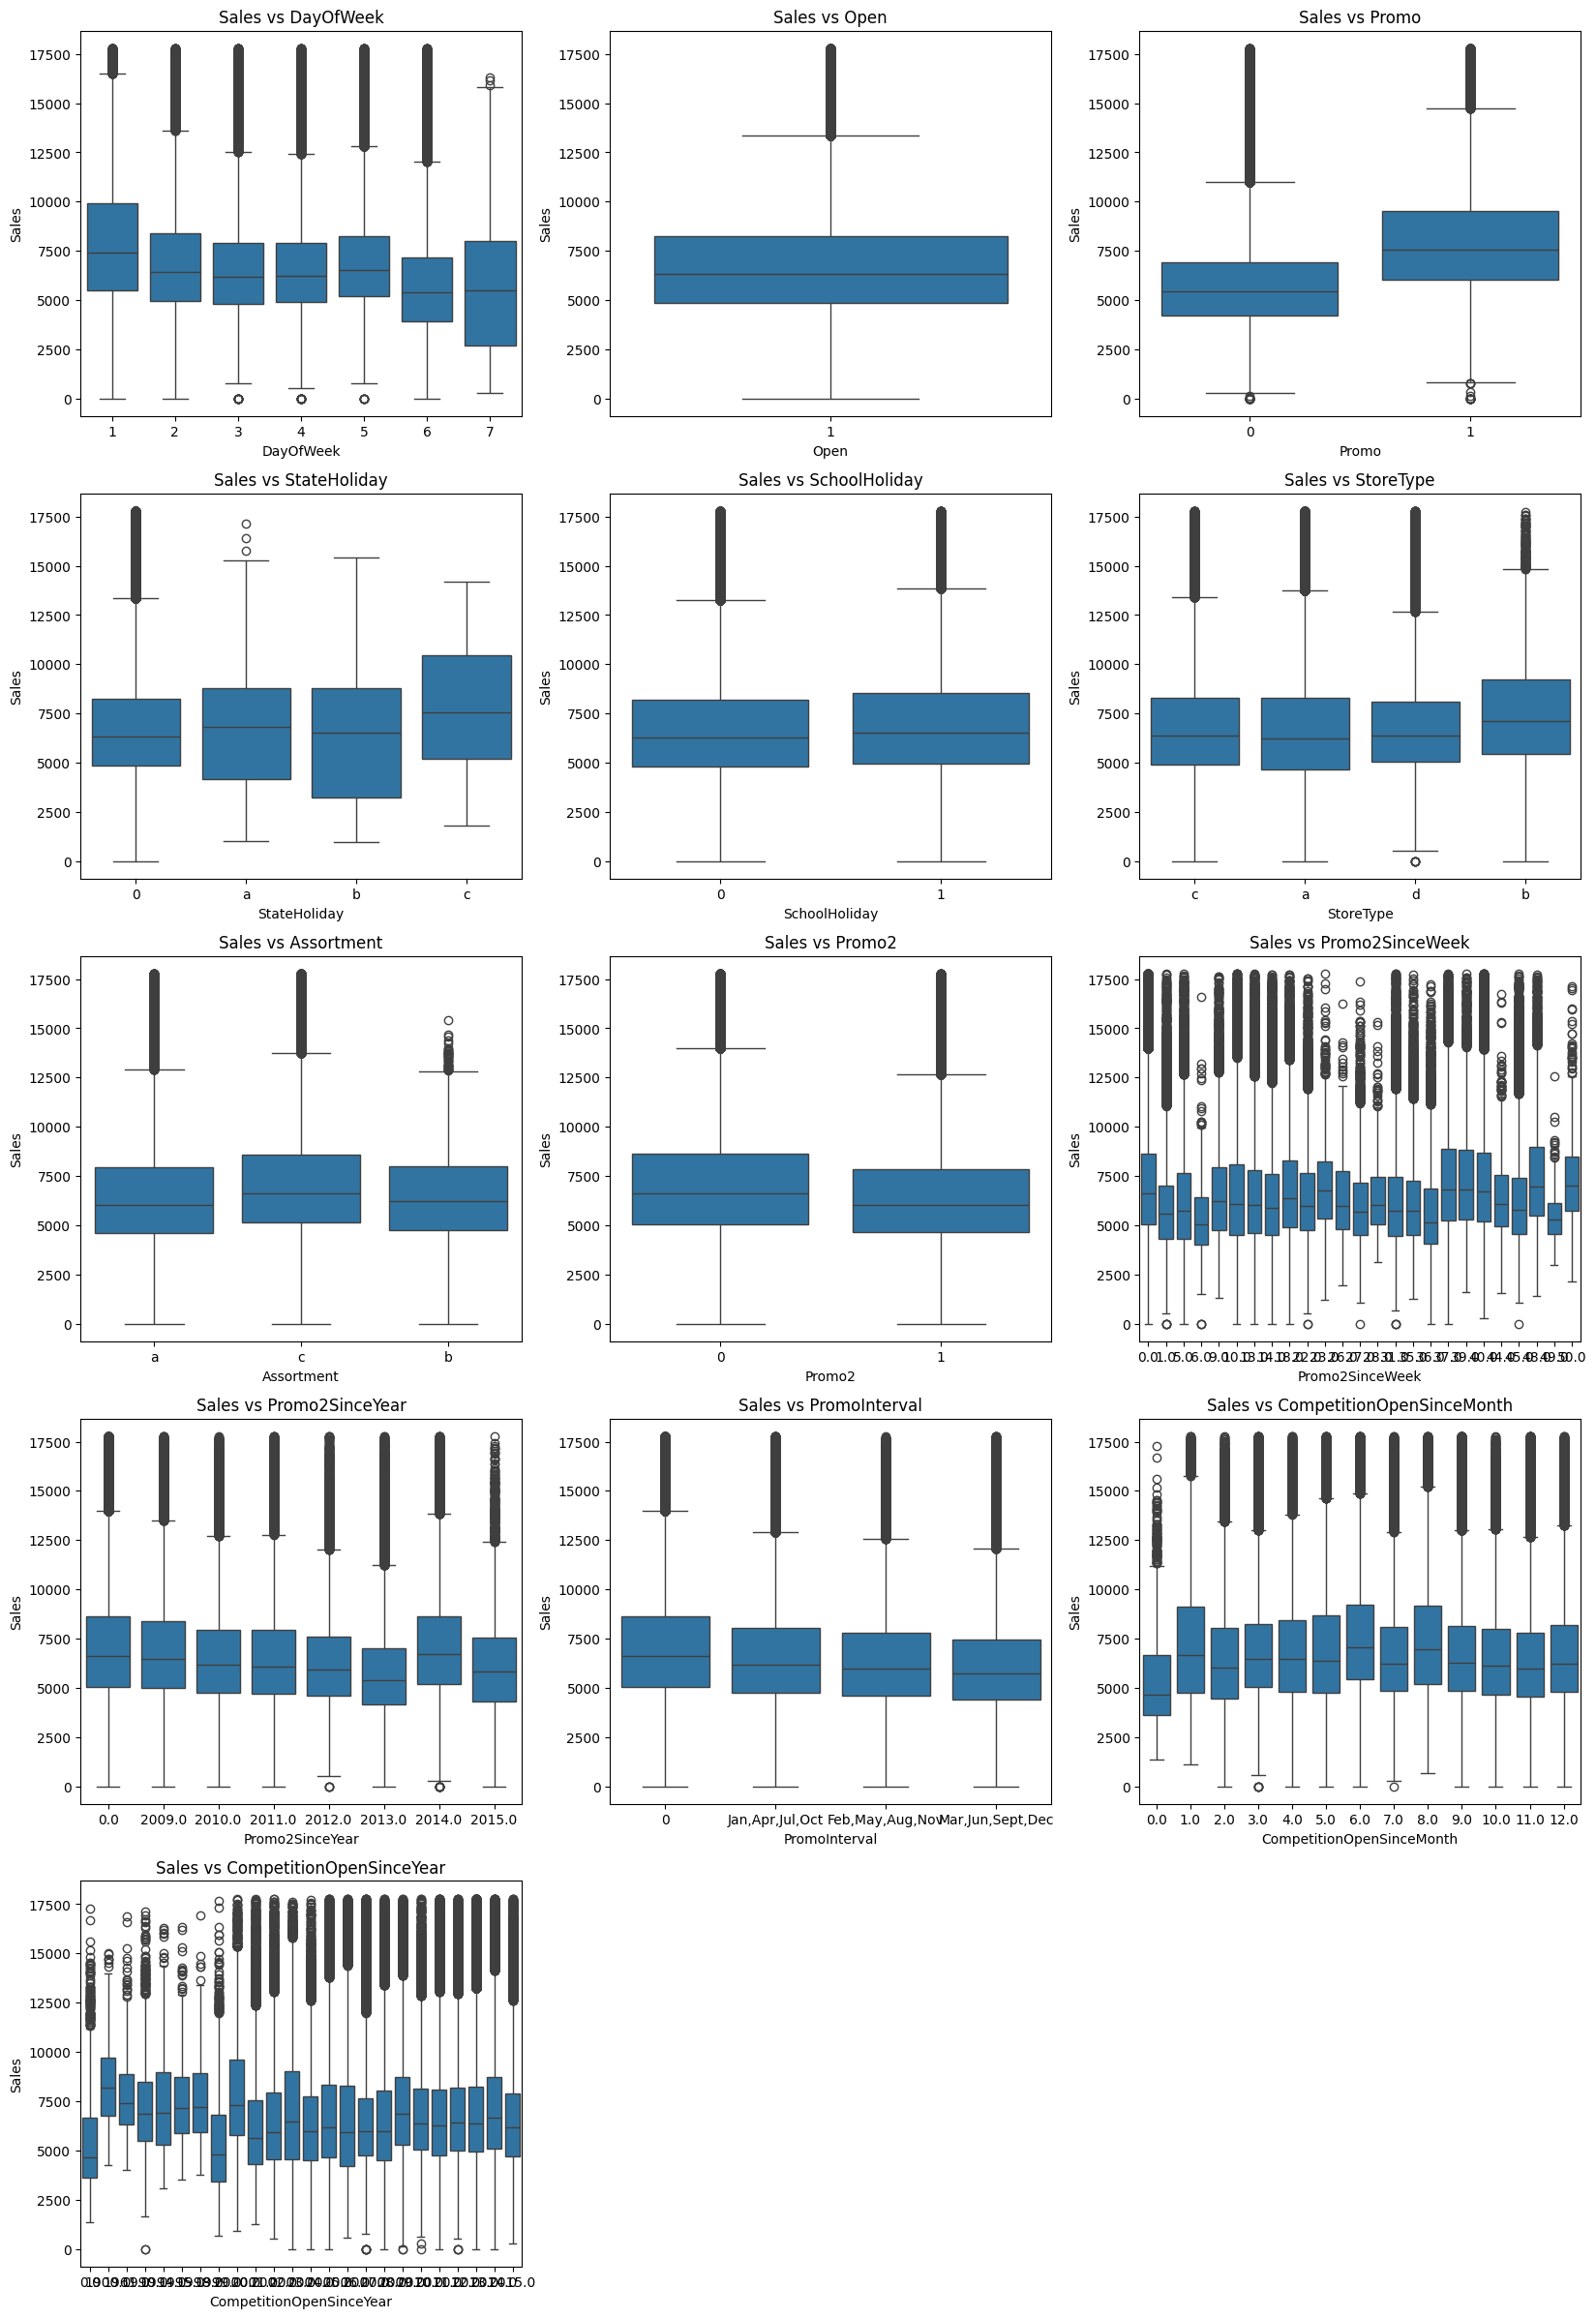

In [ ]:
# Selecting the columns to display their boxplots

bivariate_boxplotcols = ["DayOfWeek", "Open", "Promo", "StateHoliday", "SchoolHoliday", "StoreType",
                         "Assortment", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",
                         "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]

# Plotting the boxplots using "boxplot_bivariate" function

boxplot_bivariate(df_merged_transformed, bivariate_boxplotcols)

#### Inferences from the graphs of "Merged" dataset:

- Sales peak on the 1st, 2nd, and 5th weekdays, while reducing considerably on the 6th and 7th weekday.
    
- Sales exhibit a significant increase when Promo is active i.e., Promo = 1

- Sales are higher on StateHoliday = "C" when compared with "A" and "B"

- School holidays appear to have no effect on sales

- Store type "B" demonstrates a higher percentage of sales compared to other store types

- Sales are notably higher for assortment type "C"

- The columns "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval", "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" don"t have any effect on the sales

#### Scatter plot Analysis

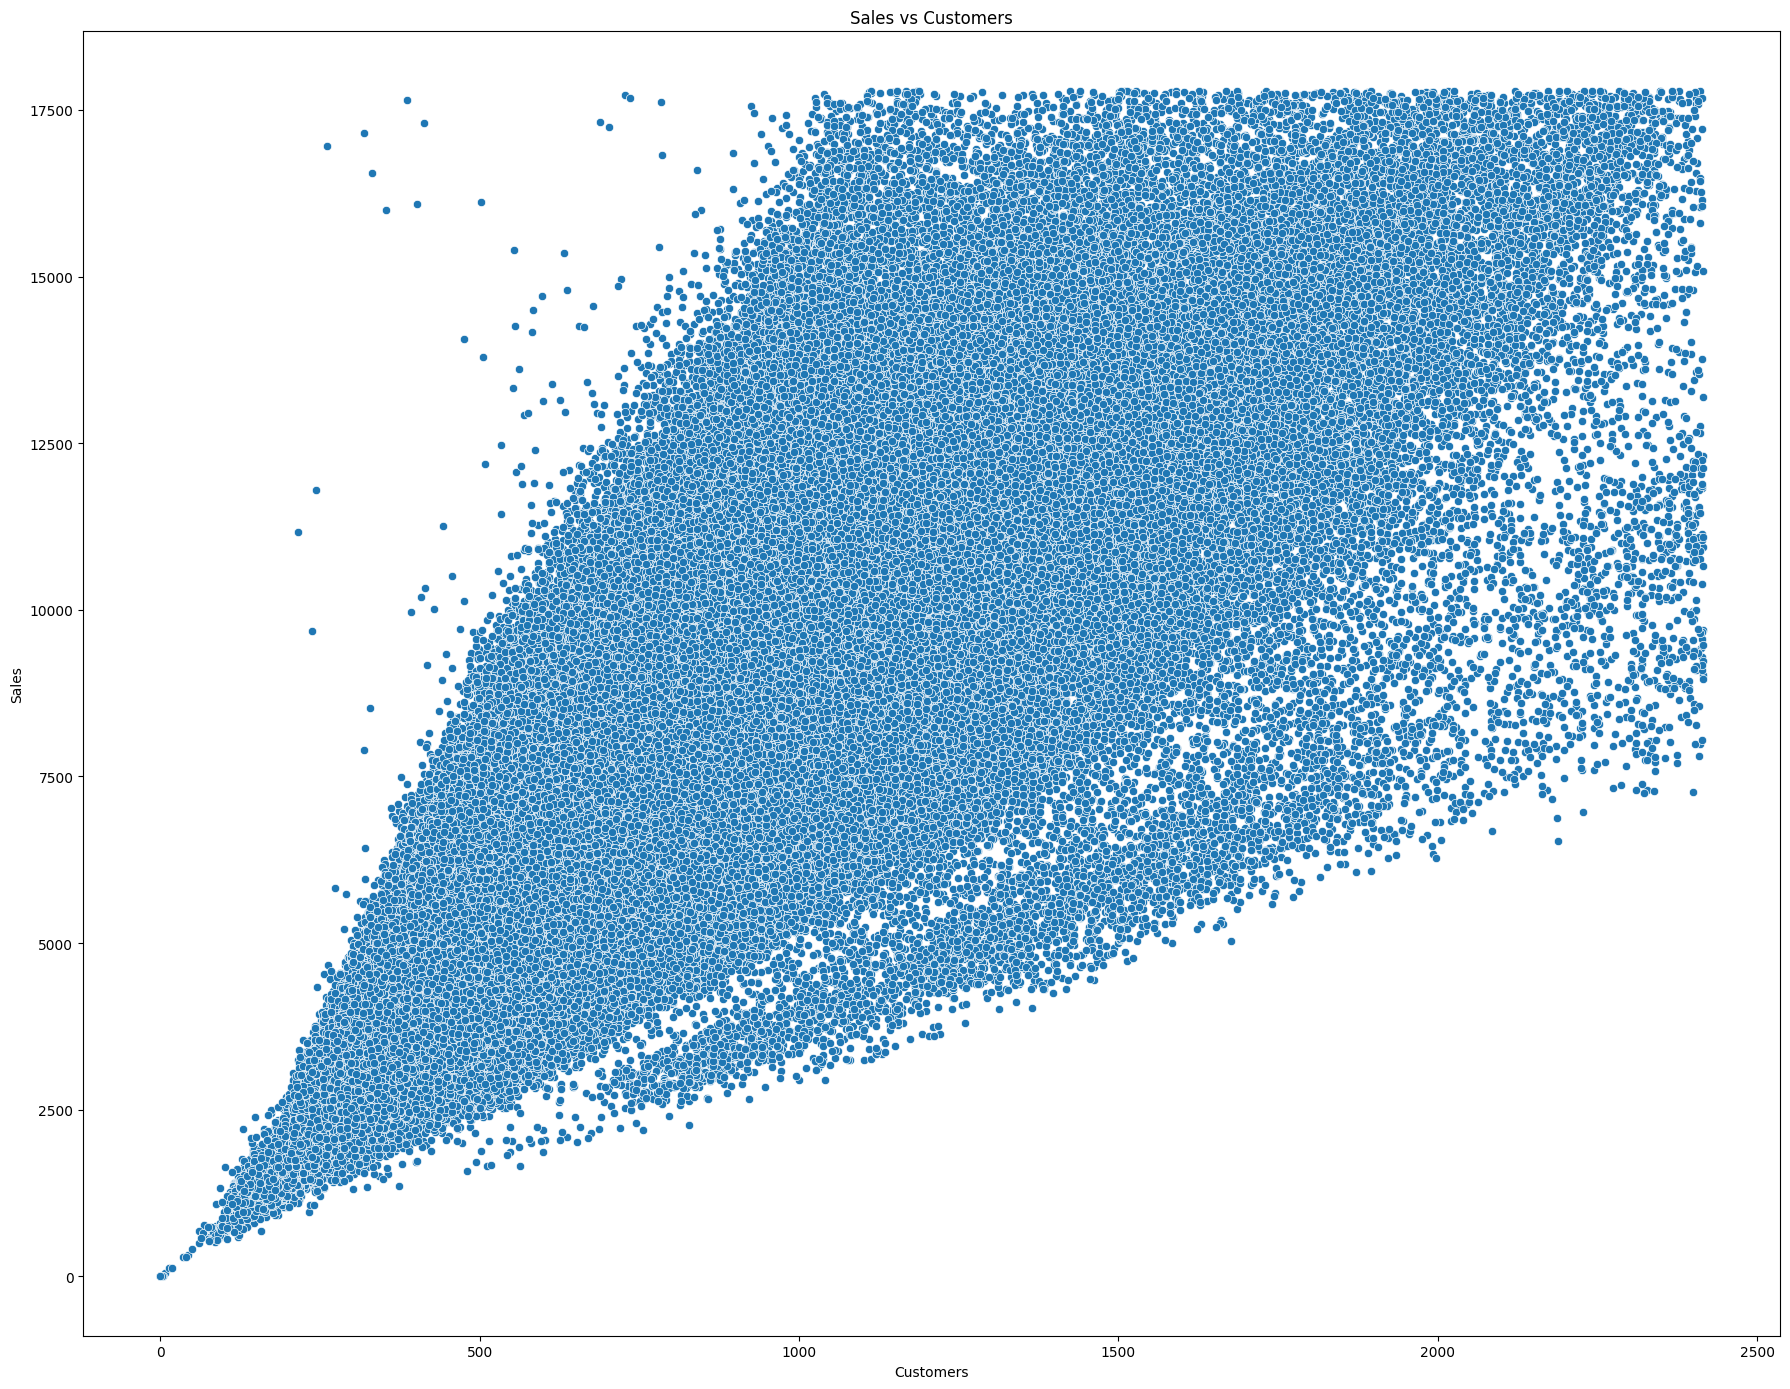

In [ ]:
# Scatter plot: Sales Vs Customers

sns.scatterplot(x = "Customers", y = "Sales", data = df_merged_transformed)
plt.title("Sales vs Customers")
plt.tight_layout()
plt.show()

#### *Inference: An increase in the number of customers correlates with higher sales.*

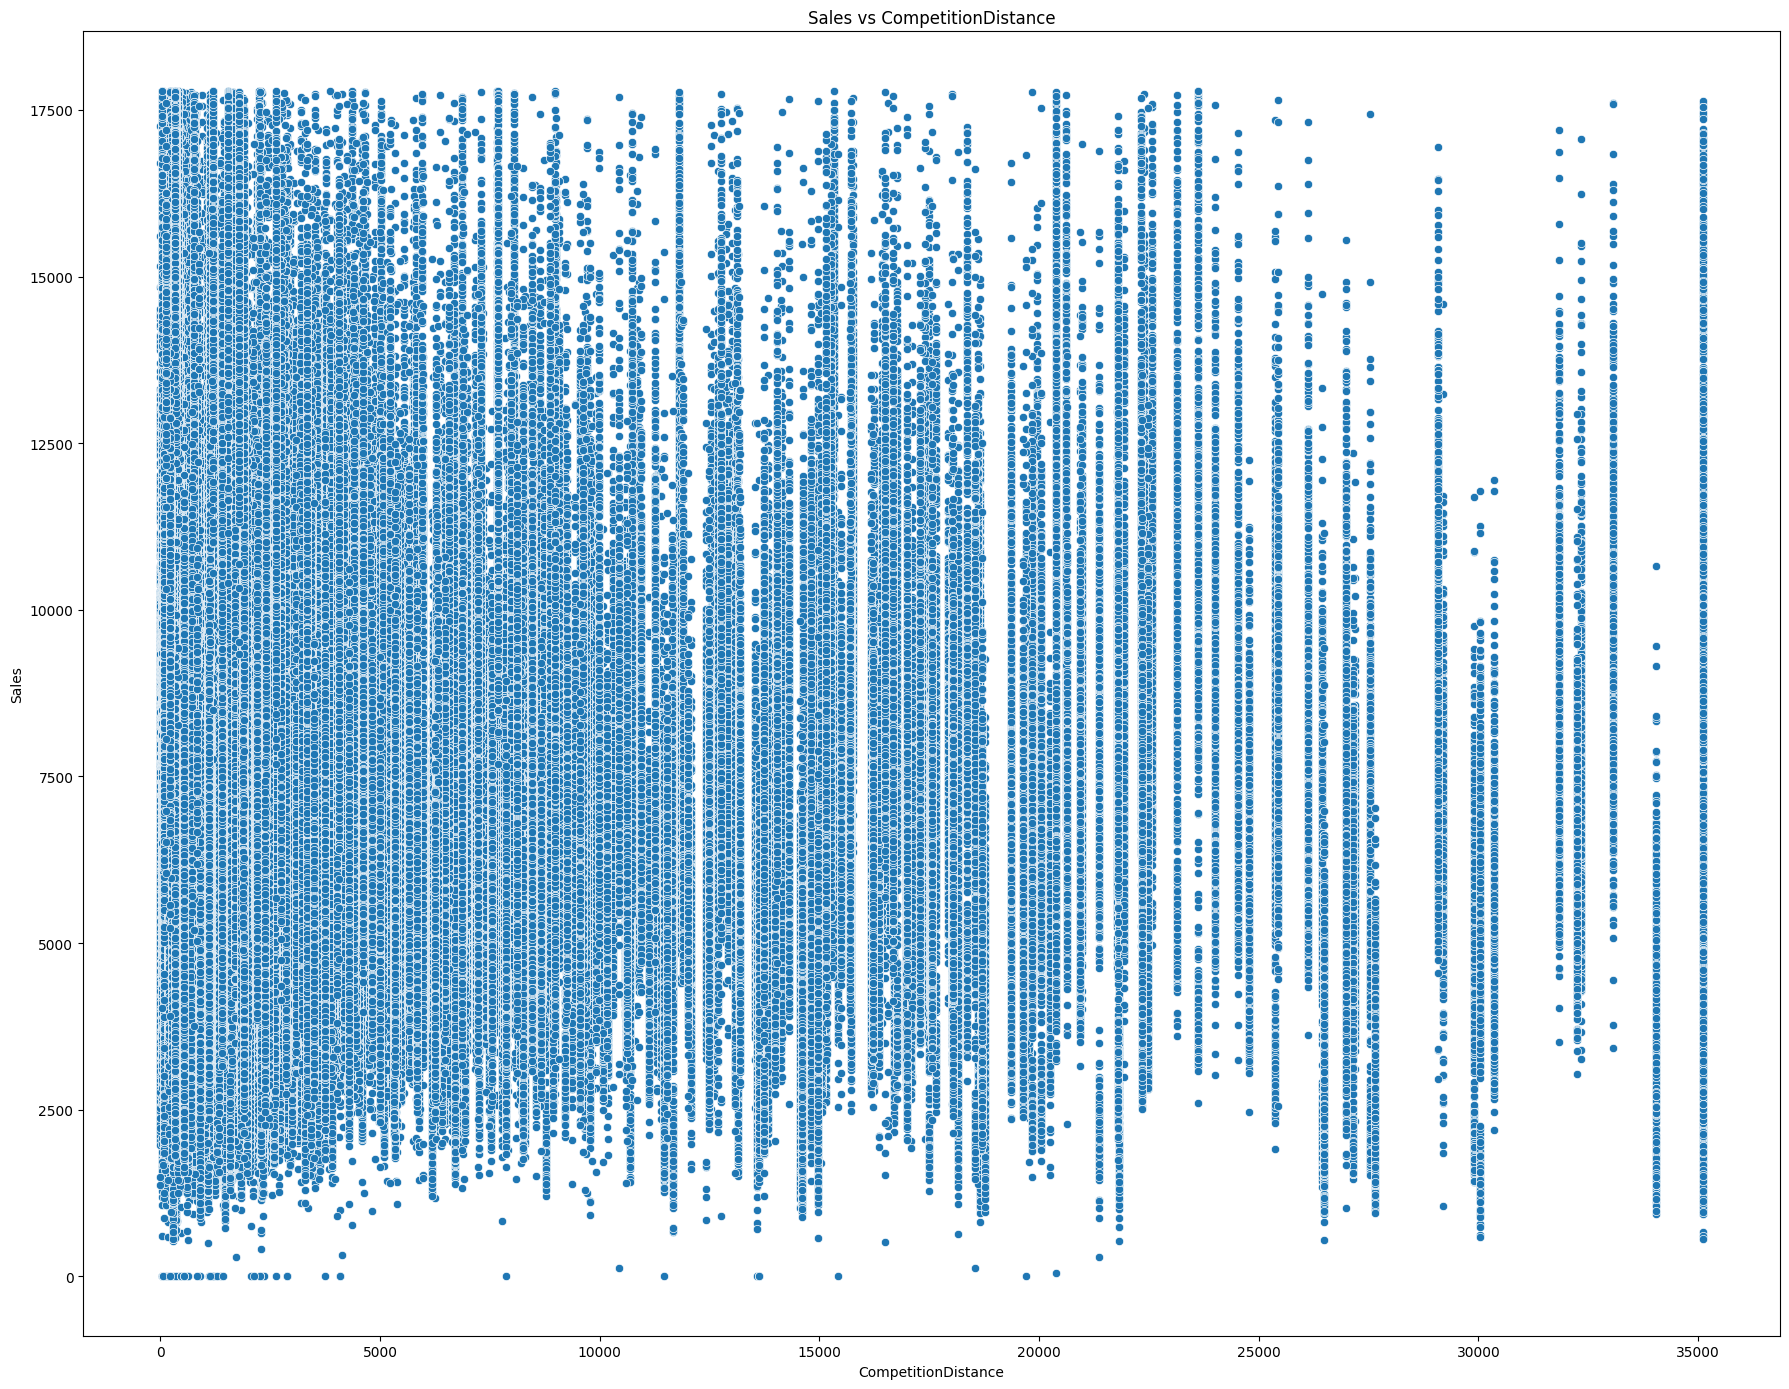

In [ ]:
# Scatter plot: Sales Vs CompetitionDistance

sns.scatterplot(x = "CompetitionDistance", y = "Sales", data = df_merged_transformed)
plt.title("Sales vs CompetitionDistance")
plt.tight_layout()
plt.show()

#### *Inference: There appears to be no correlation between "CompetitionDistance" and "Sales".*

### (iii) Multivariate Analysis

#### (a) Categorical Variables

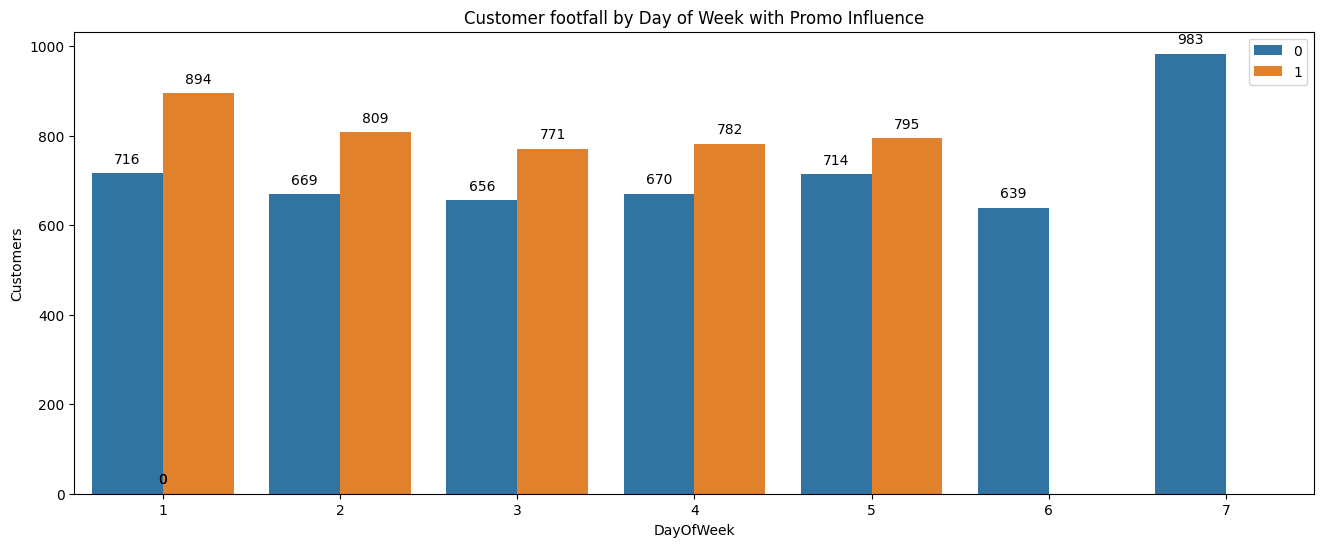

In [ ]:
# Barplot to check co-relation: Customers vs DayOfWeek with influece of "Promo"

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="DayOfWeek",y="Customers",hue="Promo", data=df_merged_transformed, ci=None)
plt.title("Customer footfall by Day of Week with Promo Influence")
plt.xticks()
plt.legend(loc="upper right")

# Add data labels at the top of each bar

for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = "center", va = "center",
                xytext = (0, 10),
                textcoords = "offset points")
plt.show()

#### Inferences-

- Weekdays witness a surge in customer numbers, particularly when promotions are in effect
- "Promo" exhibit a robust correlation with the store sales

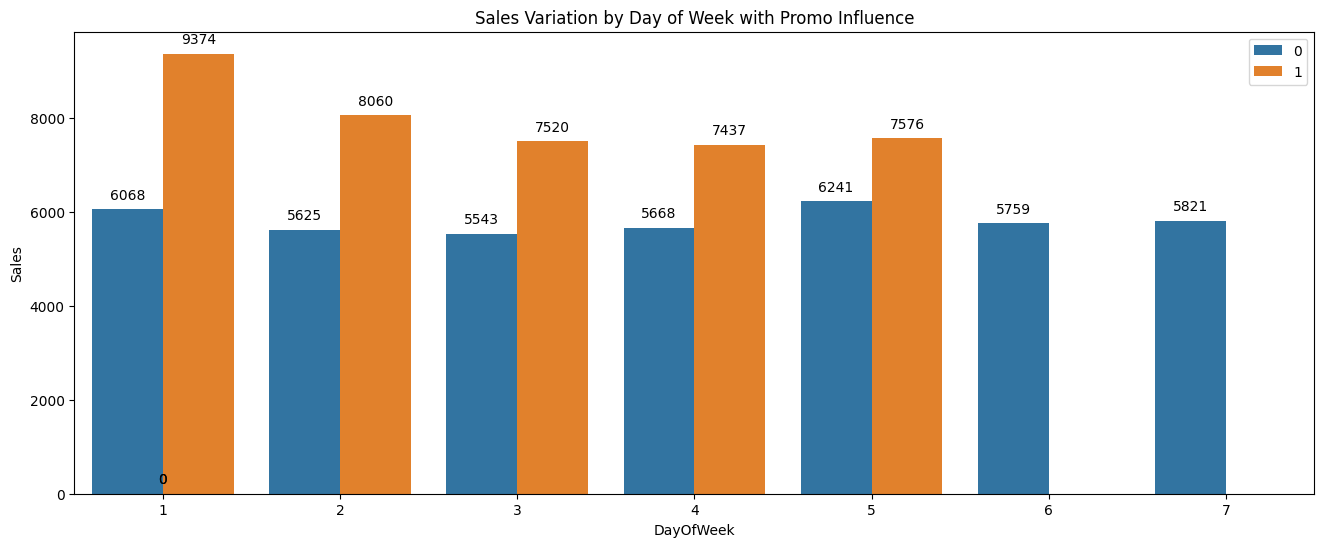

In [ ]:
# Barplot to check co-relation: Sales vs DayOfWeek with influece of "Promo"

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="DayOfWeek",y="Sales",hue="Promo", data=df_merged_transformed, ci=None)
plt.title("Sales Variation by Day of Week with Promo Influence")
plt.xticks()
plt.legend(loc="upper right")

# Add data labels at the top of each bar

for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = "center", va = "center",
                xytext = (0, 10),
                textcoords = "offset points")
plt.show()

#### Inferences-

- Sales peak on the Monday (1), Tuesday (2), and Friday (5) weekdays, while reducing considerably on Saturday (6) and Sunday (7)
- "Promo" exhibit a robust correlation with the store sales

#### (b) Numerical Variables

<Figure size 3000x3000 with 0 Axes>

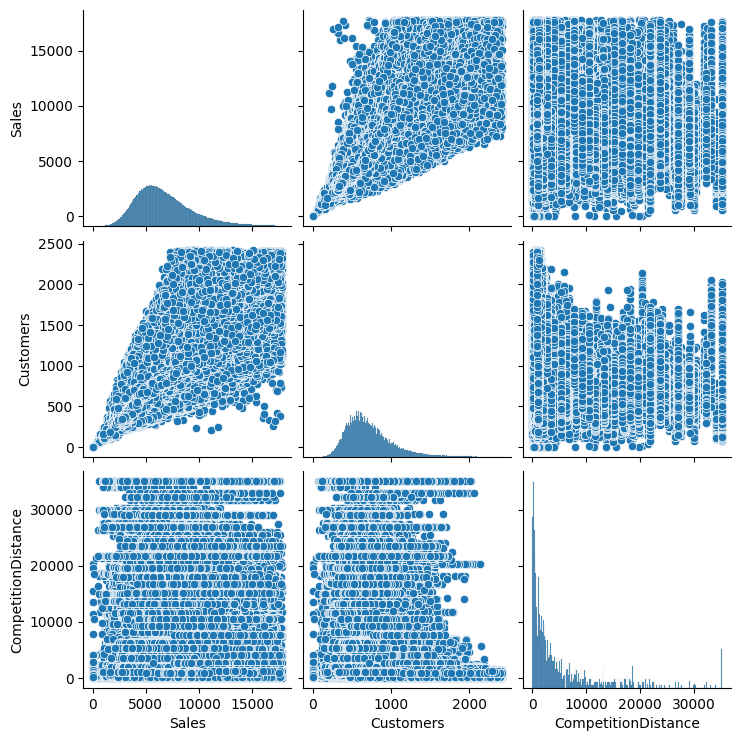

In [ ]:
# Pairwise plot

plt.figure(figsize=(30, 30))
sns.pairplot(df_merged_transformed[["Sales","Customers","CompetitionDistance"]])
plt.show()

#### *Inference: Sales tend to increase with a rise in the number of customers*

## Step 5: Feature Engineering

### Removing unwanted columns

In [ ]:
# Dropping the unnecessary columns

drop_cols = ["Promo2","SchoolHoliday","Promo2SinceWeek","Promo2SinceYear","PromoInterval",
             "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "CompetitionDistance", "Open"]

df_merge_required = df_merged_transformed.drop(drop_cols, axis=1)

In [ ]:
# Displaying the "df_merge_required" dataframe

df_merge_required.head()

Store  DayOfWeek        Date  Sales  Customers  Promo StateHoliday StoreType Assortment
0      1          5  2015-07-31   5263        555      1            0         c          a
1      1          4  2015-07-30   5020        546      1            0         c          a
2      1          3  2015-07-29   4782        523      1            0         c          a
3      1          2  2015-07-28   5011        560      1            0         c          a
4      1          1  2015-07-27   6102        612      1            0         c          a

In [ ]:
# Checking the shape of the "df_merge_required" dataframe

df_merge_required.shape

(831626, 9)

In [ ]:
# Converting "Date" to "yyyy-mm-dd" date format

df_merge_required["Date"] = pd.to_datetime(df_merge_required["Date"], format="%Y-%m-%d")

### Creating Dummy Variables

In [ ]:
# Creating Dummy Variable: "DayOfWeek"

dow_dummy = pd.get_dummies(df_merge_required.DayOfWeek, drop_first=True, prefix= "DayOfWeek")

# Creating Dummy Variable: "StoreType"

stype_dummy = pd.get_dummies(df_merge_required.StoreType, drop_first=True, prefix= "StoreType")

# Creating Dummy Variable: "Assortment"

assort_dummy = pd.get_dummies(df_merge_required.Assortment, drop_first=True, prefix= "Assortment")

# Creating Dummy Variable: "StateHoliday"

sholiday_dummy = pd.get_dummies(df_merge_required.StateHoliday, drop_first=True, prefix= "StateHoliday")

In [ ]:
# Merging all the dummies together

df_dummies_merged = pd.concat([df_merge_required, dow_dummy, stype_dummy, assort_dummy, sholiday_dummy], axis=1)

# Dropping the original columns using which dummies were formed

df_dummies_merged = df_dummies_merged.drop(["StoreType","DayOfWeek","Assortment", "StateHoliday"], axis=1)

In [ ]:
# Displaying the "df_dummies_merged" dataframe

df_dummies_merged.head(5)

Store       Date  Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
0      1 2015-07-31   5263        555      1        False        False        False         True        False        False        False         True        False         False         False            True           False           False           False
1      1 2015-07-30   5020        546      1        False        False         True        False        False        False        False         True        False         False         False            True           False           False           False
2      1 2015-07-29   4782        523      1        False         True        False        False        False        False        False         True        False         False         False            True           False           False           False
3      1 2015-07-28   5011        560      1         True        False        False        False        False        False        False         True        False         False         False            True           False           False           False
4      1 2015-07-27   6102        612      1        False        False        False        False        False        False        False         True        False         False         False            True           False           False           False

In [ ]:
# Checking the shape of the "df_dummies_merged" dataframe

df_dummies_merged.shape

(831626, 20)

In [ ]:
# Scope of analysis is for store no 1,3,8,9,13,25,29,31 and 46
ls = [1,3,8,9,13,25,29,31,46]#list of stores to be analyzed
store_sales_data=df_dummies_merged[df_dummies_merged['Store'].isin(ls)]
#store_data = store_data.set_index('Store')
df_dummies_merged.head()

### Analyzing the variables of store dataset

Store       Date  Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
0      1 2015-07-31   5263        555      1        False        False        False         True        False        False        False         True        False         False         False            True           False           False           False
1      1 2015-07-30   5020        546      1        False        False         True        False        False        False        False         True        False         False         False            True           False           False           False
2      1 2015-07-29   4782        523      1        False         True        False        False        False        False        False         True        False         False         False            True           False           False           False
3      1 2015-07-28   5011        560      1         True        False        False        False        False        False        False         True        False         False         False            True           False           False           False
4      1 2015-07-27   6102        612      1        False        False        False        False        False        False        False         True        False         False         False            True           False           False           False

In [ ]:
#splitting the data for 9 stores
store={}
for i in ls:
    store[i]=store_sales_data[store_sales_data['Store']==i]
    #store_open[i]['Date']=pd.to_datetime(store[i]['Date'],format='%Y-%m-%d')
    store[i].set_index('Date',inplace=True)
    store[i].sort_index(inplace=True)
    #store[i].index = pd.DatetimeIndex(store[i].index).to_period('D')
for i in ls:
    print('Store no.',i,':',store[i].shape)

Store no. 1 : (781, 19)
Store no. 3 : (779, 19)
Store no. 8 : (784, 19)
Store no. 9 : (779, 19)
Store no. 13 : (621, 19)
Store no. 25 : (737, 19)
Store no. 29 : (779, 19)
Store no. 31 : (784, 19)
Store no. 46 : (622, 19)


In [ ]:
store_sales_data_open = df_train_open

In [ ]:
#splitting the data for 9 stores for the days store is open
store_open={}
for i in ls:
    store_open[i]=store_sales_data_open[store_sales_data_open['Store']==i]
    #store_open[i]['Date']=pd.to_datetime(store[i]['Date'],format='%Y-%m-%d')
    store_open[i].set_index('Date',inplace=True)
    store_open[i].sort_index(inplace=True)
    #store[i].index = pd.DatetimeIndex(store[i].index).to_period('D')
    store_open[i].drop('Open',axis=1,inplace=True)
for i in ls:
    print('Store no.',i,':',store_open[i].shape)

Store no. 1 : (781, 7)
Store no. 3 : (779, 7)
Store no. 8 : (784, 7)
Store no. 9 : (779, 7)
Store no. 13 : (621, 7)
Store no. 25 : (752, 7)
Store no. 29 : (779, 7)
Store no. 31 : (784, 7)
Store no. 46 : (622, 7)


In [ ]:
store_open[1].head()

Store  DayOfWeek  Sales  Customers  Promo StateHoliday  SchoolHoliday
Date                                                                             
2013-01-02      1          3   5530        668      0            0              1
2013-01-03      1          4   4327        578      0            0              1
2013-01-04      1          5   4486        619      0            0              1
2013-01-05      1          6   4997        635      0            0              1
2013-01-07      1          1   7176        785      1            0              1

## Step 6: Time Series Analysis

#### *Insight: Based on our analysis done earlier, we observed that a rise in the number of customers leads directly to an increase in sales. Hence, the count of customers can be considered as an endogenous variable for our predictions.*

In [ ]:
df_dummies_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831626 entries, 0 to 831625
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           831626 non-null  int64         
 1   Date            831626 non-null  datetime64[ns]
 2   Sales           831626 non-null  int64         
 3   Customers       831626 non-null  int64         
 4   Promo           831626 non-null  int64         
 5   DayOfWeek_2     831626 non-null  bool          
 6   DayOfWeek_3     831626 non-null  bool          
 7   DayOfWeek_4     831626 non-null  bool          
 8   DayOfWeek_5     831626 non-null  bool          
 9   DayOfWeek_6     831626 non-null  bool          
 10  DayOfWeek_7     831626 non-null  bool          
 11  StoreType_b     831626 non-null  bool          
 12  StoreType_c     831626 non-null  bool          
 13  StoreType_d     831626 non-null  bool          
 14  Assortment_b    831626 non-null  boo

In [ ]:
# Setting "Date" as index

df_dummies_transformed = df_dummies_merged.set_index("Date")

In [ ]:
# Disiplaying the "df_dummies_transformed" dataframe

df_dummies_transformed.head()

Store  Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_0  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                                       
2015-07-31      1   5263        555      1        False        False        False         True        False        False        False         True        False         False         False            True           False           False           False
2015-07-30      1   5020        546      1        False        False         True        False        False        False        False         True        False         False         False            True           False           False           False
2015-07-29      1   4782        523      1        False         True        False        False        False        False        False         True        False         False         False            True           False           False           False
2015-07-28      1   5011        560      1         True        False        False        False        False        False        False         True        False         False         False            True           False           False           False
2015-07-27      1   6102        612      1        False        False        False        False        False        False        False         True        False         False         False            True           False           False           False

In [ ]:
# Checking the shape of "df_dummies_transformed" dataframe

df_dummies_transformed.shape

(831626, 19)

In [ ]:
# Aggregating the data for building models

df_train_grouped = df_dummies_transformed.groupby(["Date"]).agg({"Sales": "mean",
                                                                 "Customers":"mean",
                                                                 "Promo": "sum",
                                                                 "DayOfWeek_2":"mean","DayOfWeek_3":"mean",
                                                                 "DayOfWeek_4":"mean","DayOfWeek_5":"mean",
                                                                 "DayOfWeek_6":"mean","DayOfWeek_7":"mean",
                                                                 "StoreType_b" : "mean","StoreType_c" : "mean","StoreType_d" : "mean",
                                                                 "Assortment_b":"mean", "Assortment_c":"mean",
                                                                 "StateHoliday_a":"mean","StateHoliday_b":"mean","StateHoliday_c":"mean"})

In [ ]:
# Displaying the "df_train_grouped" dataframe

df_train_grouped.head()

Sales    Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                        
2013-01-01  4998.000000  1038.500000      0          1.0          0.0          0.0          0.0          0.0          0.0     0.937500     0.000000     0.000000      0.562500      0.125000             1.0             0.0             0.0
2013-01-02  6132.214545   732.165455      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011818     0.132727     0.313636      0.007273      0.457273             0.0             0.0             0.0
2013-01-03  5648.392015   673.737750      0          0.0          0.0          1.0          0.0          0.0          0.0     0.011797     0.132486     0.313067      0.007260      0.458258             0.0             0.0             0.0
2013-01-04  5908.981818   692.341818      0          0.0          0.0          0.0          1.0          0.0          0.0     0.010909     0.131818     0.313636      0.006364      0.457273             0.0             0.0             0.0
2013-01-05  5289.219290   606.239308      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011829     0.131938     0.314832      0.006369      0.456779             0.0             0.0             0.0

In [ ]:
# Checking the shape of the "df_train_grouped" dataframe

df_train_grouped.shape

(942, 17)

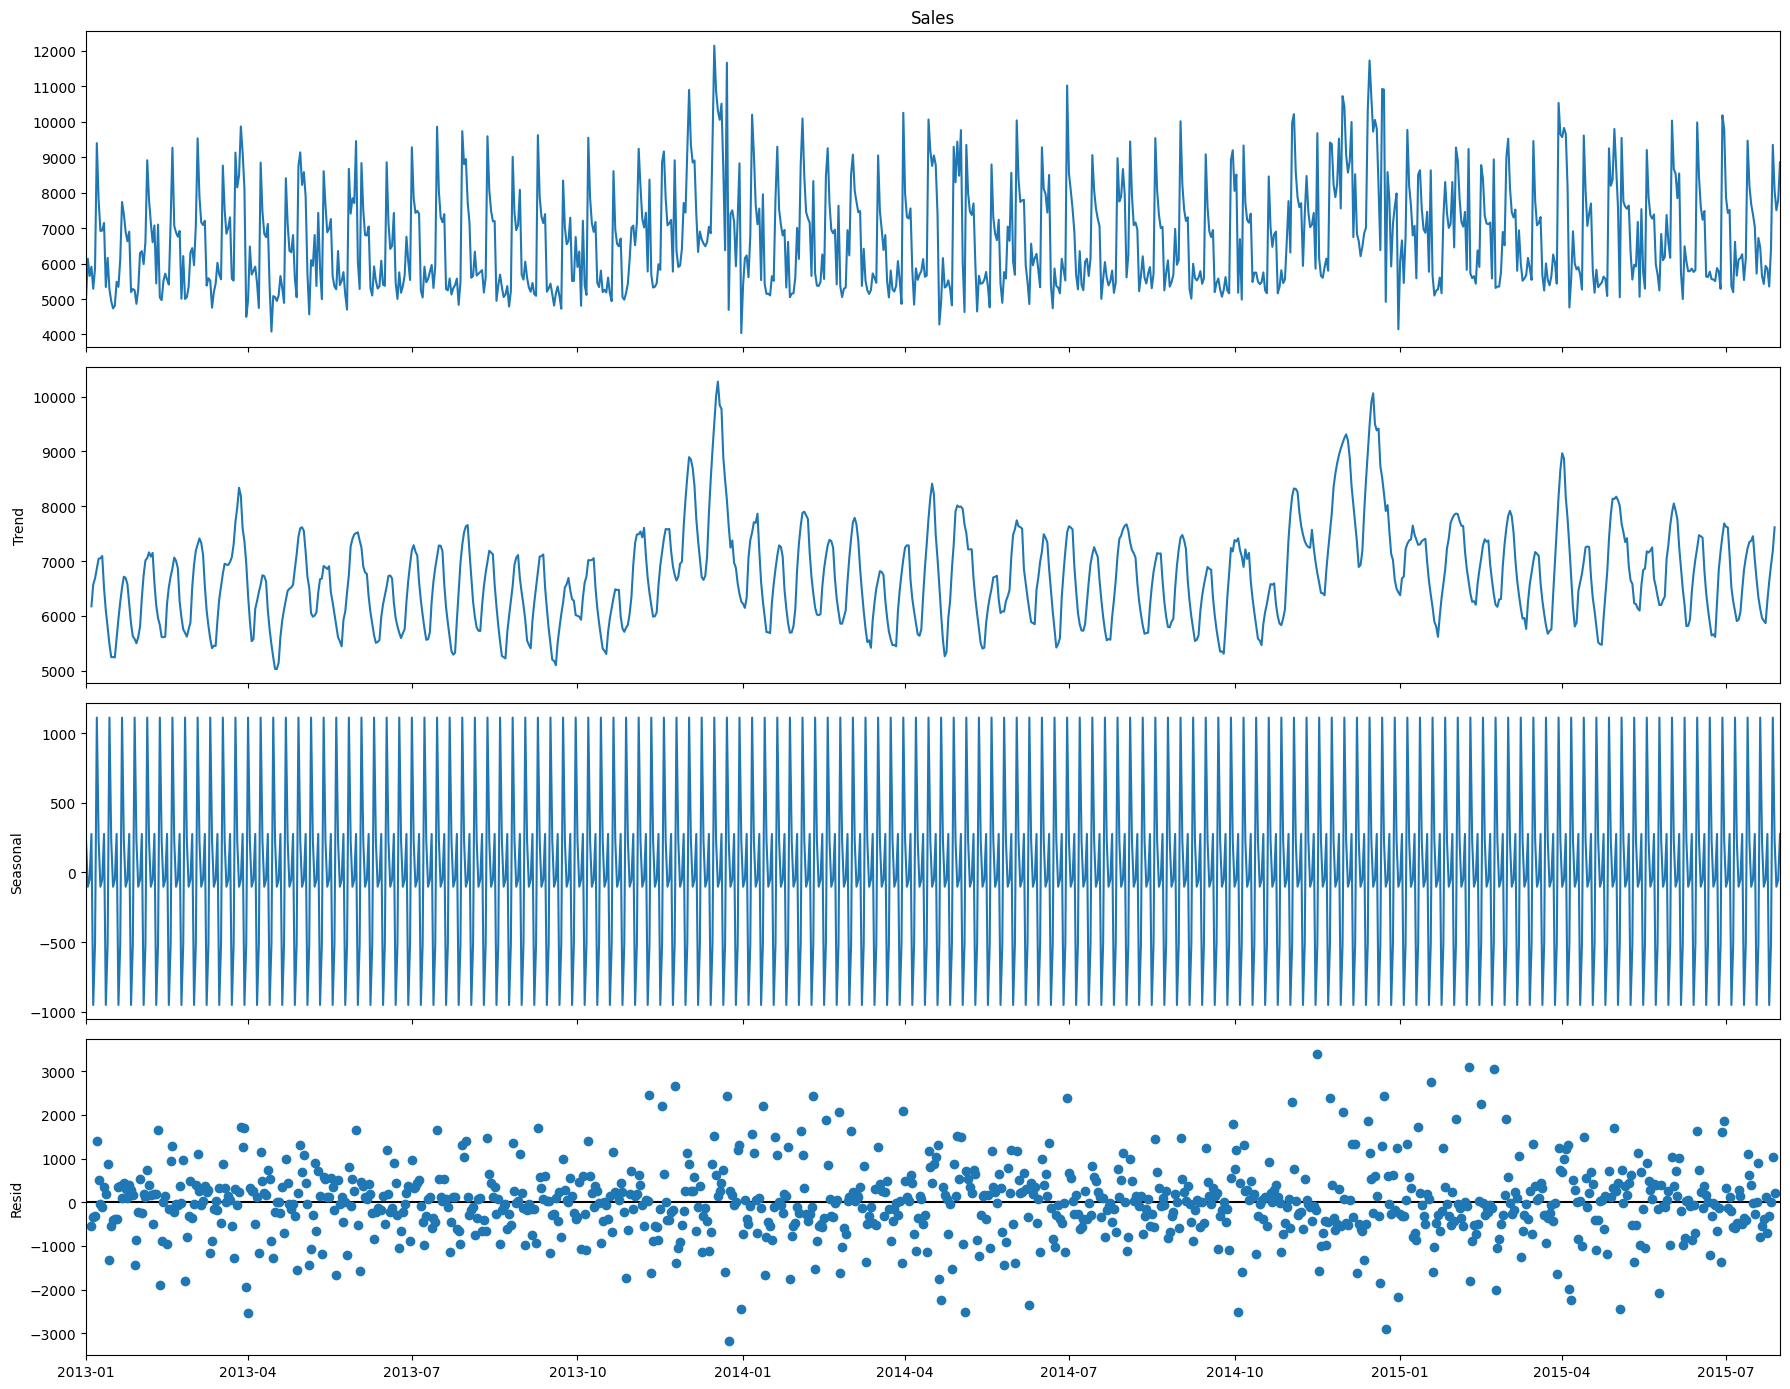

In [ ]:
# Seasonal Decomposition: "Additive"

add_decomposition = sm.tsa.seasonal_decompose(df_train_grouped.Sales, model="additive")
fig = add_decomposition.plot()
plt.show()

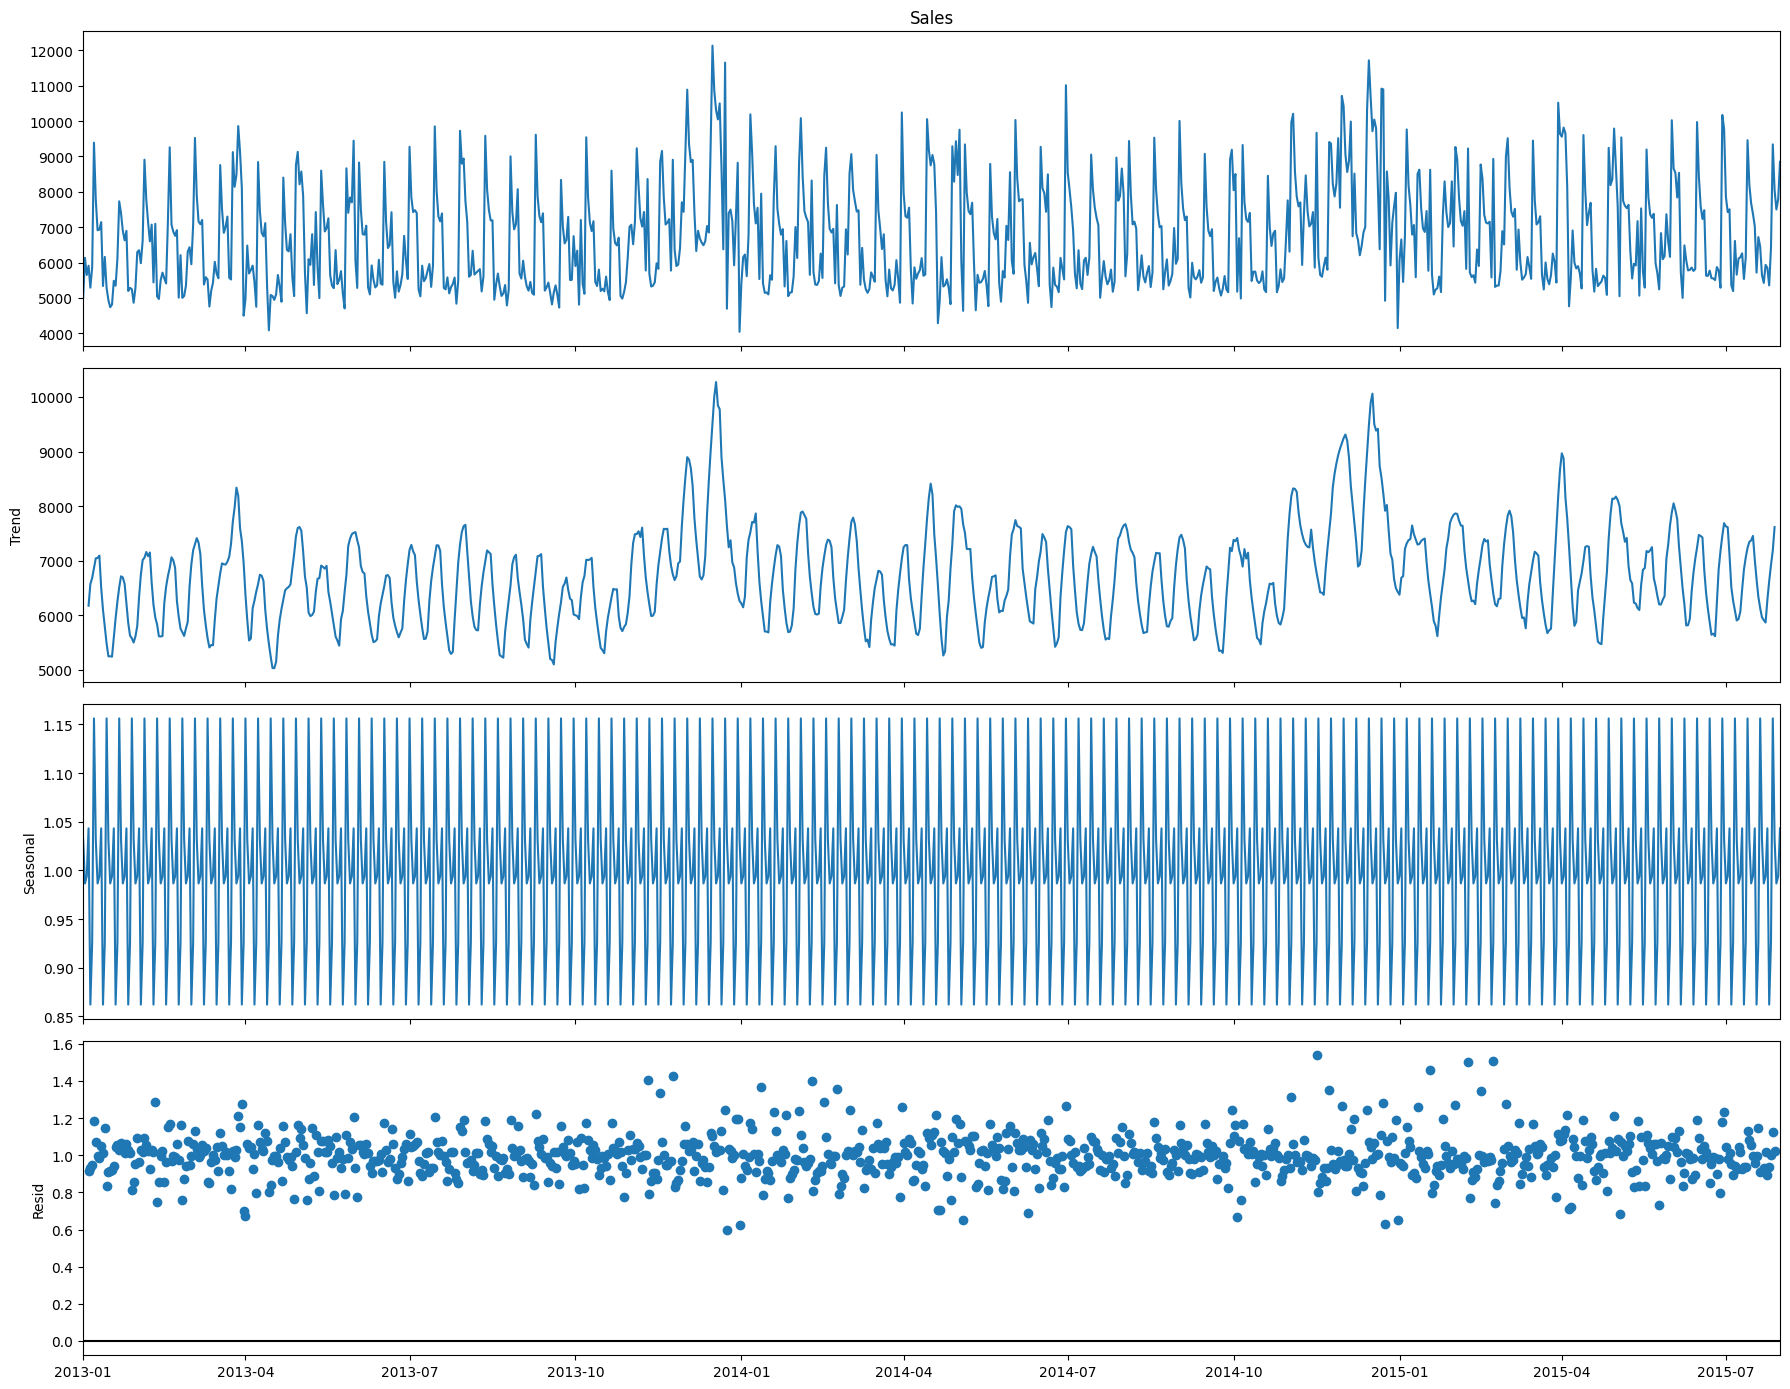

In [ ]:
# Seasonal Decomposition: "Multiplicative"

multiply_decomposition = sm.tsa.seasonal_decompose(df_train_grouped.Sales, model="multiplicative")
fig = multiply_decomposition.plot()
plt.show()

### Normalizing Sales and Customers columns:

In [ ]:


from sklearn.preprocessing import StandardScaler
def scaling(og_data,attri='Sales'):
    scaler = StandardScaler()#using standardscaler
    values = og_data[attri].values
    values=values.reshape(len(values),1)
    scaler_sale = scaler.fit(values)
    scaled_data = pd.Series(scaler.transform(values).reshape(-1),index=og_data.index)
    og_data[attri]=scaled_data
    return scaler_sale,og_data
scale_sales,train=scaling(df_train_grouped,'Sales')
scale_cust,train=scaling(df_train_grouped,'Customers')
train.head()

Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                   
2013-01-01 -1.171340   1.325511      0          1.0          0.0          0.0          0.0          0.0          0.0     0.937500     0.000000     0.000000      0.562500      0.125000             1.0             0.0             0.0
2013-01-02 -0.398989  -0.309092      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011818     0.132727     0.313636      0.007273      0.457273             0.0             0.0             0.0
2013-01-03 -0.728451  -0.620863      0          0.0          0.0          1.0          0.0          0.0          0.0     0.011797     0.132486     0.313067      0.007260      0.458258             0.0             0.0             0.0
2013-01-04 -0.551000  -0.521592      0          0.0          0.0          0.0          1.0          0.0          0.0     0.010909     0.131818     0.313636      0.006364      0.457273             0.0             0.0             0.0
2013-01-05 -0.973032  -0.981035      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011829     0.131938     0.314832      0.006369      0.456779             0.0             0.0             0.0

### Checking for Stationarity

#### (i) Column: "Sales"

In [ ]:
# Creating a copy

df_train_data = df_train_grouped.copy()

In [ ]:
# Adfuller test

adf_test = adfuller(df_train_data["Sales"])

print("ADF Statistics: ", adf_test[0])
print("Critical Value @ 0.05: ", adf_test[4]["5%"])
print("p-value: ", adf_test[1])

if adf_test[0]<adf_test[4]["5%"] and adf_test[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -4.584875354682676
Critical Value @ 0.05:  -2.8646798473884134
p-value:  0.00013771989697272606
Series is stationary


In [ ]:
# Differencing the series

df_sales_diff = pd.Series(df_train_data["Sales"].diff(), index = df_train_data.index)
df_sales_diff.dropna(inplace=True)

In [ ]:
# Displaying the "df_sales_diff" dataframe

df_sales_diff.head()

Date
2013-01-02    0.772351
2013-01-03   -0.329462
2013-01-04    0.177450
2013-01-05   -0.422031
2013-01-06    0.388677
Name: Sales, dtype: float64

In [ ]:
# Adfuller test

adf_test_diff = adfuller(df_sales_diff)

print("ADF Statistics: ", adf_test_diff[0])
print("Critical Value @ 0.05: ", adf_test_diff[4]["5%"])
print("p-value: ", adf_test_diff[1])

if adf_test_diff[0] < adf_test_diff[4]["5%"] and adf_test_diff[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -12.098351631041284
Critical Value @ 0.05:  -2.8646832620852853
p-value:  2.0456054451300134e-22
Series is stationary


#### (ii) Column: "Customers"

In [ ]:
# Adfuller test

adf_test_cust = adfuller(df_train_data["Customers"])

print("ADF Statistics: ", adf_test_cust[0])
print("Critical Value @ 0.05: ", adf_test_cust[4]["5%"])
print("p-value: ", adf_test_cust[1])

if adf_test[0]<adf_test[4]["5%"] and adf_test_cust[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is not stationary")

ADF Statistics:  -4.936845983238032
Critical Value @ 0.05:  -2.8646662624723502
p-value:  2.9550318634818664e-05
Series is stationary


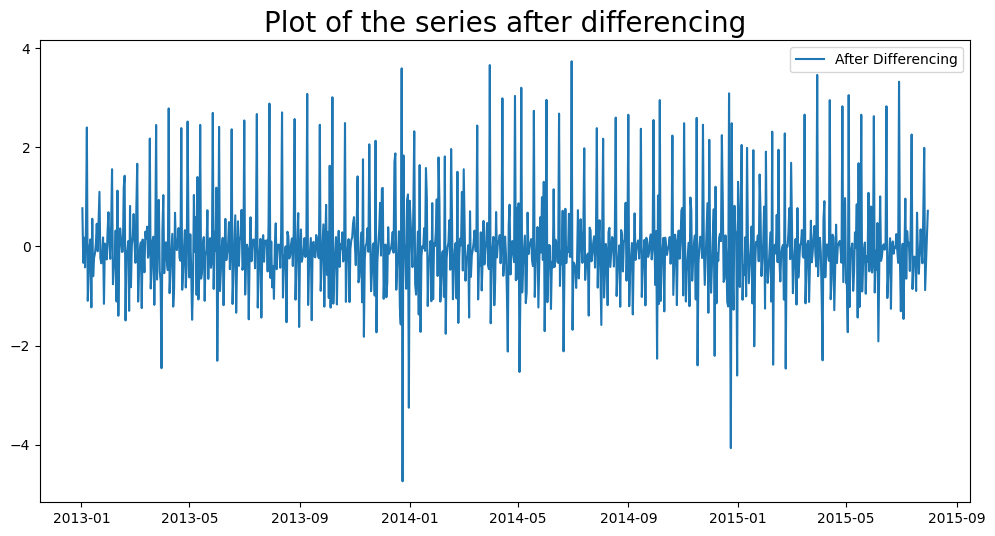

In [ ]:
# Plotting the "Difference" series

plt.figure(figsize=[12,6])
plt.plot(df_sales_diff, label="After Differencing")
plt.title("Plot of the series after differencing", size=20)
plt.legend(loc = "best")
plt.show()

Both sale and customers appear to move together and are cointegrated.

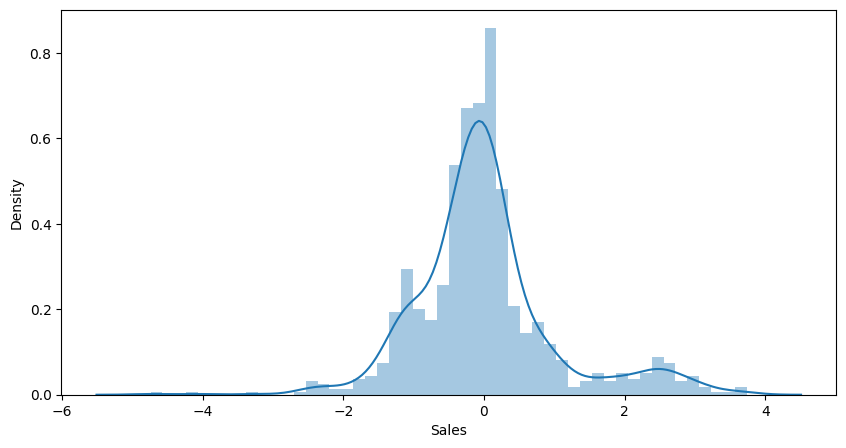

In [ ]:
# Distribution plot for "df_sales_diff"

plt.figure(figsize=(10,5))
sns.distplot(df_sales_diff)
plt.show()

#### *Inference: "Sales" and "Customers" columns are stationary* and we <u> don"t need  box-cox transformation </u>.

### Plotting ACF and PACF Plots

#### Column: "Sales"

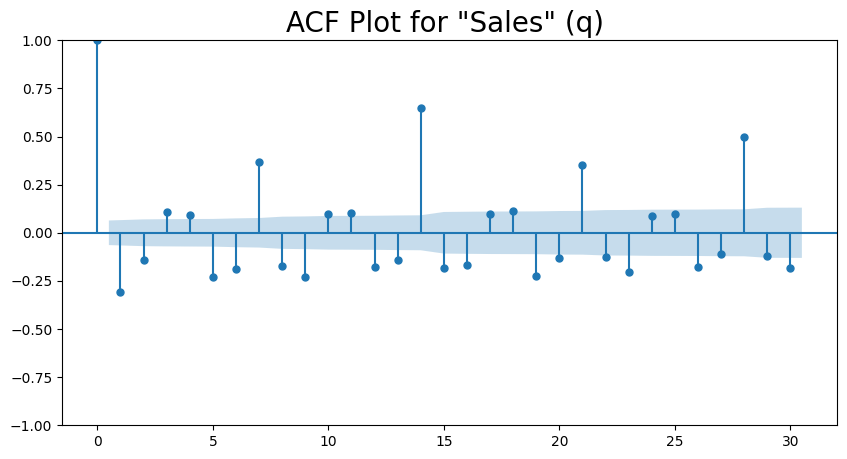

In [ ]:
# ACF Plot for "Sales" column with 30 lags

plt.figure(figsize=[10,5])
plot_acf(df_sales_diff, ax=plt.gca(), lags=30)
plt.title("ACF Plot for \"Sales\" (q) ", size=20, color="black")
plt.show()

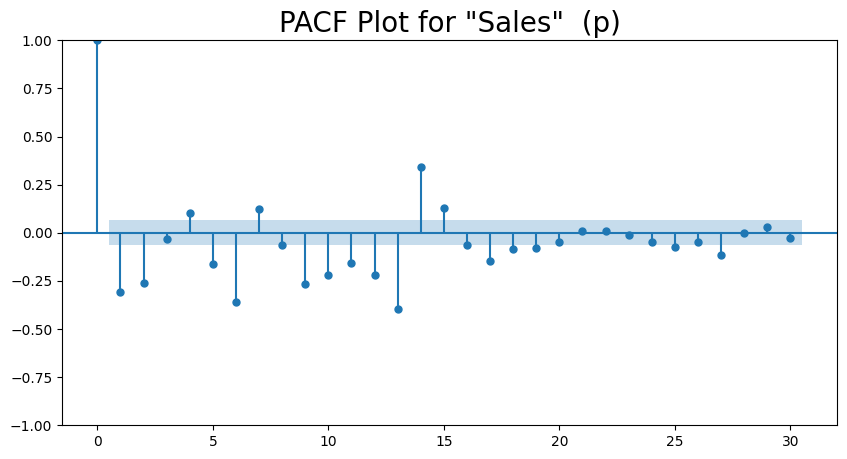

In [ ]:
# PACF Plot for "Sales" column with 30 lags

plt.figure(figsize=[10,5])
plot_pacf(df_sales_diff, ax=plt.gca(), lags=30)
plt.title("PACF Plot for \"Sales\"  (p)", size=20, color="black")
plt.show()

#### *Inference*:
From the autocorrelation plots it seems that significant lags for p  and q but still it is not very clear that exactly which lags should be considered
- p = 6
- q = 1 or 7

We can majorly use two methods for finding the best hyperparameters.

- Using the autocorrelation plots
- Cross validation with various possibilities of hyperparameters

### Train & Test Data Split

- As we have to predict for the 6 weeks, we will 42 days as our "Test" dataset.

In [ ]:
df_train_data.shape

(942, 17)

In [ ]:
# Selecting 900 (942 - 90) as the length of our "Train" Dataset

len_train = 900

df_train_values = df_train_data[:len_train]
df_test_values = df_train_data[len_train:]

In [ ]:
# Displaying the "Train" dataset

df_train_values.head()

Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                   
2013-01-01 -1.171340   1.325511      0          1.0          0.0          0.0          0.0          0.0          0.0     0.937500     0.000000     0.000000      0.562500      0.125000             1.0             0.0             0.0
2013-01-02 -0.398989  -0.309092      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011818     0.132727     0.313636      0.007273      0.457273             0.0             0.0             0.0
2013-01-03 -0.728451  -0.620863      0          0.0          0.0          1.0          0.0          0.0          0.0     0.011797     0.132486     0.313067      0.007260      0.458258             0.0             0.0             0.0
2013-01-04 -0.551000  -0.521592      0          0.0          0.0          0.0          1.0          0.0          0.0     0.010909     0.131818     0.313636      0.006364      0.457273             0.0             0.0             0.0
2013-01-05 -0.973032  -0.981035      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011829     0.131938     0.314832      0.006369      0.456779             0.0             0.0             0.0

In [ ]:
# Checking the shape of "Train" dataset

df_train_values.shape

(900, 17)

In [ ]:
# Displaying the "Test" dataset

df_test_values.head()

Sales  Customers  Promo  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  StoreType_b  StoreType_c  StoreType_d  Assortment_b  Assortment_c  StateHoliday_a  StateHoliday_b  StateHoliday_c
Date                                                                                                                                                                                                                                   
2015-06-20 -0.740522  -0.959248      0          0.0          0.0          0.0          0.0          1.0          0.0     0.011775     0.134058     0.314312      0.006341      0.458333             0.0             0.0             0.0
2015-06-21 -0.746999   0.557331      0          0.0          0.0          0.0          0.0          0.0          1.0     0.423077     0.000000     0.115385      0.192308      0.538462             0.0             0.0             0.0
2015-06-22 -0.644354  -0.711776      0          0.0          0.0          0.0          0.0          0.0          0.0     0.009058     0.134058     0.315217      0.004529      0.461957             0.0             0.0             0.0
2015-06-23 -0.789463  -0.796460      0          1.0          0.0          0.0          0.0          0.0          0.0     0.009955     0.133937     0.314932      0.005430      0.461538             0.0             0.0             0.0
2015-06-24 -0.795712  -0.784446      0          0.0          1.0          0.0          0.0          0.0          0.0     0.011743     0.133695     0.314363      0.006323      0.460705             0.0             0.0             0.0

In [ ]:
# Checking the shape of the "Test" dataset

df_test_values.shape

(42, 17)

### Model 1: AR Model (Auto Regression)  || Config (p,d,q) = (6, 0 ,0)

In [ ]:
# Syntax ARIMA(p,d,q)

# Using p = 6

model_AR = sm.tsa.arima.ARIMA(df_sales_diff, order=(6, 0, 0))
model_AR_fit = model_AR.fit()
print(model_AR_fit.params)

const     0.001186
ar.L1    -0.434786
ar.L2    -0.227875
ar.L3    -0.041016
ar.L4    -0.050754
ar.L5    -0.302625
ar.L6    -0.367942
sigma2    0.713880
dtype: float64


In [ ]:
# Retrieving the series

y_hat_ar = df_sales_diff.copy()

y_hat_ar["ar_forecast_diff"] = model_AR_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_ar["ar_forecast"] = y_hat_ar["ar_forecast_diff"].cumsum()

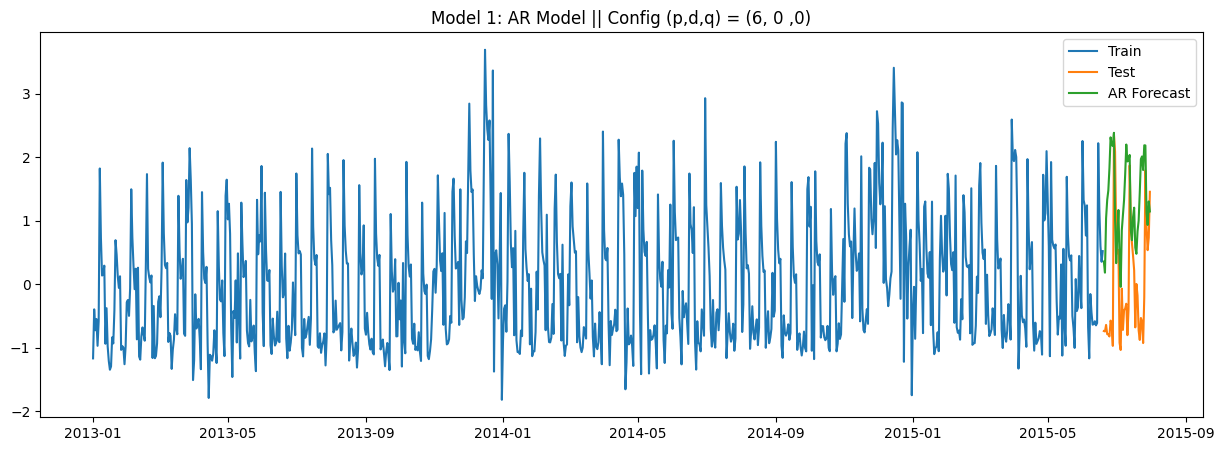

In [ ]:
# Plotting the Train, Test and AR forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_ar["ar_forecast"][df_test_values.index.min():], label="AR Forecast")
plt.legend(loc="best")
plt.title("Model 1: AR Model || Config (p,d,q) = (6, 0 ,0)")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 1: AR Model (6,0,0)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_ar["ar_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_ar["ar_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

results = pd.DataFrame({"Method":["AR Method"], "RMSE": [rmse],"MAPE": [mape] })
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE    MAPE
0  AR Method  1.71  973.12

### Model 2: MA Model (Moving Average)  || Config (p,d,q) = (0, 0 ,1)

In [ ]:
# Syntax ARIMA(p,d,q)

# Using q = 1

model_MA = sm.tsa.arima.ARIMA(df_sales_diff, order=(0, 0, 1))
model_MA_fit = model_MA.fit()
print(model_MA_fit.params)

const     0.002102
ma.L1    -0.453729
sigma2    0.871359
dtype: float64


In [ ]:
# Retrieving the series

y_hat_ma = df_sales_diff.copy()

y_hat_ma["mavg_forecast_diff"] = model_MA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_ma["mavg_forecast"] = y_hat_ma["mavg_forecast_diff"].cumsum()

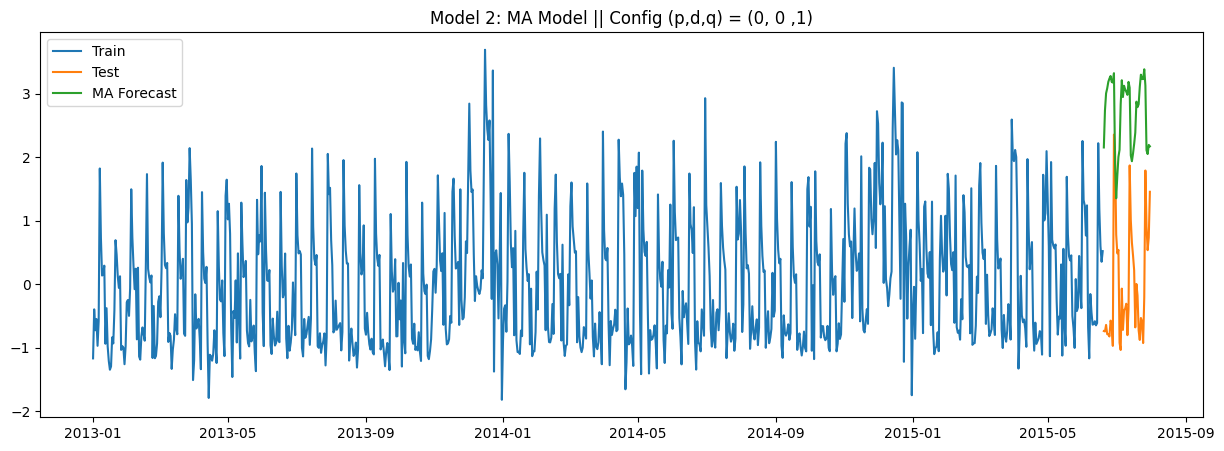

In [ ]:
# Plotting the Train, Test and MA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_ma["mavg_forecast"][df_test_values.index.min():], label="MA Forecast")
plt.legend(loc="best")
plt.title("Model 2: MA Model || Config (p,d,q) = (0, 0 ,1)")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 2: MA Model (0,0,1)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_ma["mavg_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_ma["mavg_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["MA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE     MAPE
0  AR Method  1.71   973.12
0  MA Method  3.00  6834.44

### Model 3: ARIMA Model  || Config (p,d,q) = (6, 0 ,1)

In [ ]:
# Syntax ARIMA(p,d,q)

# Using p = 6 and q = 1

model_ARIMA = sm.tsa.arima.ARIMA(df_sales_diff, order=(6, 0, 1))
model_ARIMA_fit = model_ARIMA.fit()
print(model_ARIMA_fit.params)

const     0.001337
ar.L1    -0.662448
ar.L2    -0.312345
ar.L3    -0.095892
ar.L4    -0.058664
ar.L5    -0.295621
ar.L6    -0.409676
ma.L1     0.266155
sigma2    0.703760
dtype: float64


In [ ]:
# Retrieving the series

y_hat_arima = df_sales_diff.copy()

y_hat_arima["arima_forecast_diff"] = model_ARIMA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_arima["arima_forecast"] = y_hat_arima["arima_forecast_diff"].cumsum()

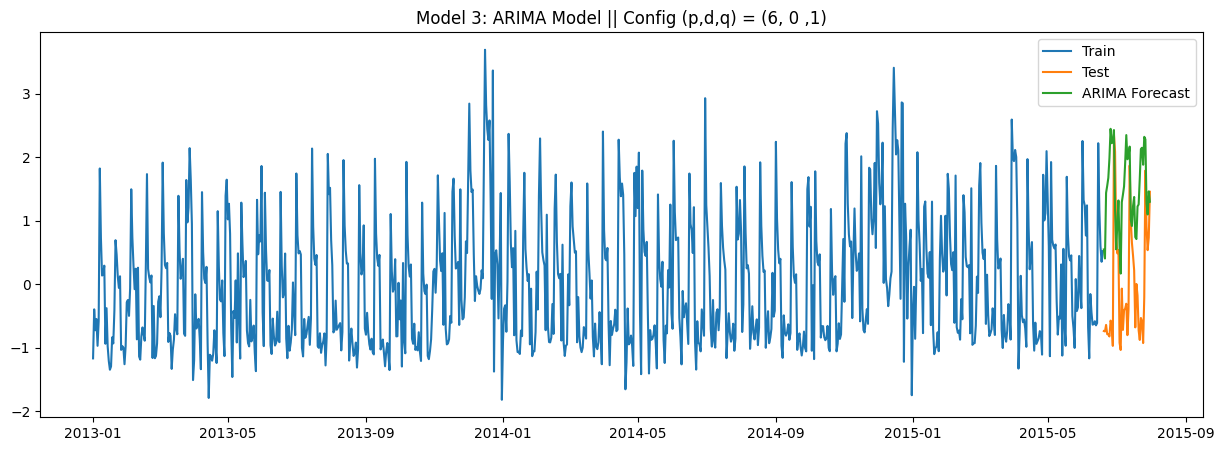

In [ ]:
# Plotting the Train, Test and ARIMA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_arima["arima_forecast"][df_test_values.index.min():], label="ARIMA Forecast")
plt.legend(loc="best")
plt.title("Model 3: ARIMA Model || Config (p,d,q) = (6, 0 ,1)")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 3: ARIMA Model (6,0,1)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_arima["arima_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_arima["arima_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["ARIMA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE     MAPE
0     AR Method  1.71   973.12
0     MA Method  3.00  6834.44
0  ARIMA Method  1.84  1529.96

### Model 4: SARIMA Model  || Config (p,d,q, s) = (6, 0 ,1, 12)

In [ ]:
# Since we have yearly data, we will take the "s" parameter as 12
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMA = SARIMAX(df_sales_diff, order=(6,0,1), seasonal_order=(6,0,1,12))
model_SARIMA_fit = model_SARIMA.fit()
print(model_SARIMA_fit.params)

ar.L1      -0.556246
ar.L2      -0.182488
ar.L3      -0.016006
ar.L4      -0.021552
ar.L5      -0.255791
ar.L6      -0.384751
ma.L1       0.143372
ar.S.L12   -0.669442
ar.S.L24   -0.173451
ar.S.L36   -0.070273
ar.S.L48    0.013851
ar.S.L60   -0.005707
ar.S.L72   -0.132801
ma.S.L12    0.567349
sigma2      0.679532
dtype: float64


In [ ]:
# Retrieving the series

y_hat_sarima = df_sales_diff.copy()

y_hat_sarima["sarima_forecast_diff"] = model_SARIMA_fit.predict(df_sales_diff.index.min(), df_sales_diff.index.max())

y_hat_sarima["sarima_forecast"] = y_hat_sarima["sarima_forecast_diff"].cumsum()

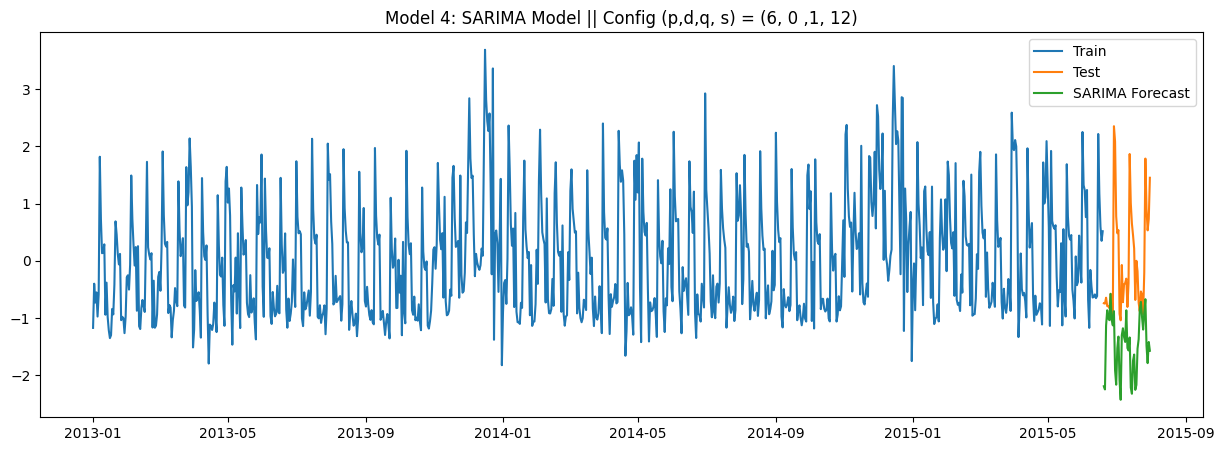

In [ ]:
# Plotting the Train, Test and SARIMA forecasts

plt.figure(figsize=(15,5))
plt.plot(df_train_data["Sales"][:len_train], label="Train")
plt.plot(df_train_data["Sales"][len_train:], label="Test")
plt.plot(y_hat_sarima["sarima_forecast"][df_test_values.index.min():], label="SARIMA Forecast")
plt.legend(loc="best")
plt.title("Model 4: SARIMA Model || Config (p,d,q, s) = (6, 0 ,1, 12)")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 4: SARIMA Model (6,0,1,12)

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], y_hat_sarima["sarima_forecast"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-y_hat_sarima["sarima_forecast"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["SARIMA Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE     MAPE
0      AR Method  1.71   973.12
0      MA Method  3.00  6834.44
0   ARIMA Method  1.84  1529.96
0  SARIMA Method  1.80  5485.74

### Model 5: VAR Model

In [ ]:
# VAR Model

exog = df_train_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                        "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]]
endog = df_train_values[["Sales", "Customers"]]
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)

print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.632      -4.524    0.009732      -4.591
1       -4.900      -4.770    0.007450      -4.850
2       -4.896      -4.745    0.007473      -4.839
3       -4.913      -4.740    0.007348      -4.847
4       -4.916      -4.721    0.007328      -4.842
5       -4.959      -4.743    0.007018      -4.877
6       -5.086      -4.848    0.006181      -4.995
7       -5.108      -4.849    0.006047      -5.009
8       -5.130      -4.848    0.005919      -5.022
9       -5.166      -4.864    0.005705      -5.051
10      -5.249      -4.924    0.005255      -5.125
11      -5.327      -4.981    0.004857      -5.195
12      -5.341      -4.973    0.004794      -5.200
13      -5.355      -4.965    0.004726      -5.206
14      -5.384      -4.973    0.004591      -5.227
15     -5.428*     -4.996*   0.004391*     -5.263*
-------------------------------

In [ ]:
# Fitting the VAR Model at Lag 15 as it"s the lowest

var_model_fit = var_model.fit(15)
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Sep, 2024
Time:                     17:43:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.99576
Nobs:                     885.000    HQIC:                  -5.26297
Log likelihood:          -29.4730    FPE:                 0.00439084
AIC:                     -5.42836    Det(Omega_mle):      0.00401930
--------------------------------------------------------------------
Results for equation Sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.386806         2.143374            0.180           0.857
Promo                  0.001076         0.000069           15.703           0.000
Assortment_b          -3.805429         1.187533        

In [ ]:
#Hyperparameter Tuning of maxlags for VAR Model
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
# Function to train and evaluate the VAR model
def train_var_model(train_endog, test_endog, train_exog, test_exog, maxlags):
    model = VAR(endog=train_endog, exog=train_exog)
    var_fit = model.fit(maxlags=maxlags)

    # Forecast for the test set
    forecast = var_fit.forecast(y=train_endog.values, steps=len(test_endog), exog_future=test_exog.values)
    return forecast, var_fit

# Hyperparameter tuning function for VAR model
def var_cross_validation(endog, exog, maxlags_range, folds=5):
    tscv = TimeSeriesSplit(n_splits=folds)
    results = []

    # Iterate through all possible lag values
    for maxlags in maxlags_range:
        print(f'Testing maxlags={maxlags}...')
        rmse_list = []

        # Perform cross-validation
        for train_index, test_index in tscv.split(endog):
            train_endog, test_endog = endog.iloc[train_index], endog.iloc[test_index]
            train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

            try:
                # Train VAR model and forecast
                forecast, model_fit = train_var_model(train_endog, test_endog, train_exog, test_exog, maxlags)

                # Calculate RMSE for the current fold
                rmse = np.sqrt(mean_squared_error(test_endog, forecast))
                rmse_list.append(rmse)

            except Exception as e:
                print(f"Error for maxlags={maxlags}: {e}")
                continue

        # Calculate average RMSE across folds
        avg_rmse = np.mean(rmse_list)
        results.append({'maxlags': maxlags, 'RMSE': avg_rmse})

    # Create a DataFrame of results and find the best maxlags
    results_df = pd.DataFrame(results)
    best_lags = results_df.loc[results_df['RMSE'].idxmin()]

    print(f"\nBest Model: maxlags={best_lags['maxlags']} with RMSE: {best_lags['RMSE']}")
    return results_df

# Example usage of the function
maxlags_range = range(1, 16)  # You can adjust this range as per your requirement

# Assuming `endog` is your endogenous variables and `exog` is your exogenous variables
results_df = var_cross_validation(endog, exog, maxlags_range, folds=5)

# Print or save the results
print(results_df)

Testing maxlags=1...
Testing maxlags=2...
Testing maxlags=3...
Testing maxlags=4...
Testing maxlags=5...
Testing maxlags=6...
Testing maxlags=7...
Testing maxlags=8...
Testing maxlags=9...
Testing maxlags=10...
Testing maxlags=11...
Testing maxlags=12...
Testing maxlags=13...
Testing maxlags=14...
Testing maxlags=15...

Best Model: maxlags=4.0 with RMSE: 0.5111677694434138
    maxlags      RMSE
0         1  0.511269
1         2  0.513265
2         3  0.511280
3         4  0.511168
4         5  0.512239
5         6  0.513582
6         7  0.521476
7         8  0.529482
8         9  0.530951
9        10  0.525544
10       11  0.525747
11       12  0.527514
12       13  0.523746
13       14  0.525771
14       15  0.549487


#### Cointegration Test

In [ ]:
# Creating a UDF for checking cointegration using "Johansen Test"
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, lag):

    alpha = 0.05
    out = coint_johansen(df, -1, lag)
    d = {"0.90": 0, "0.95": 1, "0.99": 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Print summary header
    print("Name   ::  Test Stat > C(95%)    =>   Significance  ")
    print("--" * 10)

    # Print results for each column
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(f"{col.ljust(6)} :: {round(trace, 2):>9} > {cvt:8}  =>  {trace > cvt}")

In [ ]:
# Performing Johansen Test with Lag = 15


cointegration_test(df_train_values[["Sales","Customers"]],15)

rank_result=select_coint_rank(df_train_values[["Sales","Customers"]],-1,15)

Name   ::  Test Stat > C(95%)    =>   Significance  
--------------------
Sales  ::     74.54 >  12.3212  =>  True
Customers ::     24.01 >   4.1296  =>  True


In [ ]:
print(rank_result.rank)

2


#### Inferences:

- Rank = 1 suggests that the time series are co-integrated
- Hence, we can build a VAR/ VARMAX model

In [ ]:
# Calculation of the lag order

lag_order = var_model_fit.k_ar
print(lag_order)

forecast_input = df_train_values[["Sales","Customers"]].values[-lag_order:]
forecast_input

15


array([[ 1.2387907 ,  0.30938589],
       [-0.67745513, -0.88922169],
       [-1.17093099,  0.10858115],
       [-0.15835477, -0.36385352],
       [-0.44713786, -0.58330558],
       [-0.64004008, -0.71191762],
       [-0.63135266, -0.66238849],
       [-0.58617842, -0.66437319],
       [-0.65088551, -0.92676191],
       [-0.61475284,  0.59778638],
       [ 2.21760489,  0.58952817],
       [ 1.17609508,  0.10309132],
       [ 0.59672749, -0.188762  ],
       [ 0.35050885, -0.31206417],
       [ 0.51792045, -0.16346753]])

In [ ]:
# Generating the forecasts

exog_test = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                            "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)

fc = var_model_fit.forecast(y=forecast_input, steps=42, exog_future=exog_test)


var_forecast = pd.DataFrame(fc, index=df_test_values.index, columns=["Sales","Customers"])
var_forecast.head()

Sales  Customers
Date                           
2015-06-20 -0.731408  -0.869957
2015-06-21 -0.875270   0.547518
2015-06-22 -0.114472  -0.197820
2015-06-23 -0.679099  -0.582515
2015-06-24 -0.822841  -0.740561

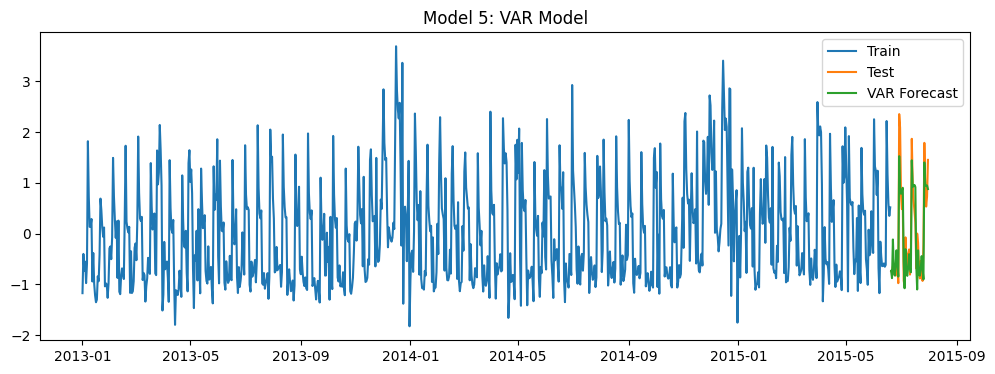

In [ ]:
# Plotting the Train, Test and VAR forecasts

plt.figure(figsize=(12,4))
plt.plot(df_train_values["Sales"], label="Train")
plt.plot(df_test_values["Sales"], label="Test")
plt.plot(var_forecast["Sales"][df_test_values.index.min():], label="VAR Forecast")
plt.legend(loc="best")
plt.title("Model 5: VAR Model")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 5: VAR Model

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], var_forecast["Sales"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-var_forecast["Sales"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["VAR Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE     MAPE
0      AR Method  1.71   973.12
0      MA Method  3.00  6834.44
0   ARIMA Method  1.84  1529.96
0  SARIMA Method  1.80  5485.74
0     VAR Method  0.41  2770.17

### Model 6: VARMAX Model

In [ ]:
# Using p = 7 and q = 0

exog = df_train_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                        "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]]

model_VARMAX = sm.tsa.VARMAX(df_train_values[["Sales", "Customers"]], order=(7,0), trend = "n", exog = exog)
res_VARMAX = model_VARMAX.fit(maxiter = 1000, disp=False)

res_VARMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Statespace Model Results                             
==================================================================================
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                -977.339
Date:                    Sun, 08 Sep 2024   AIC                           2052.678
Time:                            17:44:57   BIC                           2287.995
Sample:                        01-01-2013   HQIC                          2142.570
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
===================================================================================
Ljung-Box (L1) (Q):            0.01, 38.21   Jarque-Bera (JB):      345.58, 4358.06
Prob(Q):                        0.91, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.45, 1.23   Skew:                       0.62, 0.79
Prob(H) (two-sided):            0.00, 0.07   Kurtosis:                  5.77, 13.66
                               Results for equation Sales                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Sales                0.3721      0.047      7.890      0.000       0.280       0.465
L1.Customers            0.1328      0.037      3.561      0.000       0.060       0.206
L2.Sales                0.0832      0.050      1.650      0.099      -0.016       0.182
L2.Customers           -0.1761      0.051     -3.431      0.001      -0.277      -0.075
L3.Sales                0.1069      0.052      2.044      0.041       0.004       0.209
L3.Customers           -0.1147      0.058     -1.979      0.048      -0.228      -0.001
L4.Sales                0.0421      0.048      0.878      0.380      -0.052       0.136
L4.Customers           -0.0653      0.046     -1.405      0.160      -0.156       0.026
L5.Sales               -0.0237      0.052     -0.455      0.649      -0.126       0.079
L5.Customers           -0.0689      0.043     -1.603      0.109      -0.153       0.015
L6.Sales               -0.0258      0.065     -0.399      0.690      -0.152       0.101
L6.Customers           -0.1192      0.053     -2.246      0.025      -0.223      -0.015
L7.Sales                0.3206      0.070      4.585      0.000       0.184       0.458
L7.Customers           -0.1699      0.096     -1.776      0.076      -0.357       0.018
beta.Promo              0.0008   9.08e-05      9.285      0.000       0.001       0.001
beta.Assortment_b      -3.1417      2.127     -1.477      0.140      -7.311       1.027
beta.Assortment_c      -1.0112      0.446     -2.266      0.023      -1.886      -0.137
beta.StoreType_b        3.2259      1.080      2.987      0.003       1.109       5.343
beta.StoreType_c        2.8260      2.235      1.265      0.206      -1.554       7.206
beta.StoreType_d       -0.9673      1.337     -0.723      0.470      -3.589       1.654
beta.StateHoliday_a    -0.1321      0.272     -0.486      0.627      -0.664       0.400
beta.StateHoliday_b     0.2059      0.494      0.417      0.677      -0.762       1.174
beta.StateHoliday_c    -0.1506      0.474     -0.318      0.751      -1.080       0.778
                             Results for equation Customers                            
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Sales                0.1223      0.031      3.975     

- Model Fit:The model seems to fit well with significant effects from both Sales and Customers lagged terms on each other.
- Exogenous Variables:Promotional activities and store types have a significant positive effect on both Sales and Customers.
-- Promo: Significant positive effects on both Sales and Customers, as expected.
-- Assortment: Different types of assortments (b and c) have varying effects. Assortment b has a negative effect on both Sales and Customers, while Assortment c has a positive effect.
-- StoreType: Different store types (b, c, d) have significant positive effects on both Sales and Customers.
- Residual Diagnostics:There may be issues with autocorrelation and non-normality in the residuals, which might indicate a need for further model refinement.

In [ ]:
# Function to train and evaluate the VARMAX model
def train_varmax_model(train_endog, test_endog, train_exog, test_exog, order):
    model = sm.tsa.VARMAX(train_endog, order=order, exog=train_exog, trend='n')
    varmax_fit = model.fit(maxiter=1000, disp=False)

    # Forecast for the test set
    forecast = varmax_fit.forecast(steps=len(test_endog), exog=test_exog)
    return forecast, varmax_fit

# Hyperparameter tuning function for VARMAX model
def varmax_cross_validation(endog, exog, p_max, q_max, folds=5):
    tscv = TimeSeriesSplit(n_splits=folds)
    results = []

    # Iterate through all combinations of p and q
    for p in range(1, p_max+1):
        for q in range(0, q_max+1):
            print(f'Testing order=(p={p}, q={q})...')
            rmse_list = []

            # Perform cross-validation
            for train_index, test_index in tscv.split(endog):
                train_endog, test_endog = endog.iloc[train_index], endog.iloc[test_index]
                train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

                try:
                    # Train VARMAX model and forecast
                    forecast, model_fit = train_varmax_model(train_endog, test_endog, train_exog, test_exog, (p, q))

                    # Calculate RMSE for the current fold
                    rmse = np.sqrt(mean_squared_error(test_endog, forecast))
                    rmse_list.append(rmse)

                except Exception as e:
                    print(f"Error for order=(p={p}, q={q}): {e}")
                    continue

            # Calculate average RMSE across folds
            avg_rmse = np.mean(rmse_list)
            results.append({'order': (p, q), 'RMSE': avg_rmse})

    # Create a DataFrame of results and find the best order
    results_df = pd.DataFrame(results)
    best_order = results_df.loc[results_df['RMSE'].idxmin()]

    print(f"\nBest Model: order={best_order['order']} with RMSE: {best_order['RMSE']}")
    return results_df


p_max = 10  # Maximum p value to test
q_max = 5   # Maximum q value to test

# Assuming `endog` is your endogenous variables and `exog` is your exogenous variables
results_df = varmax_cross_validation(df_train_values[["Sales", "Customers"]], exog, p_max, q_max, folds=5)

# Print or save the results
print(results_df)

Testing order=(p=1, q=0)...
Testing order=(p=1, q=1)...
Testing order=(p=1, q=2)...
Testing order=(p=1, q=3)...
Testing order=(p=1, q=4)...
Testing order=(p=1, q=5)...
Testing order=(p=2, q=0)...
Testing order=(p=2, q=1)...
Testing order=(p=2, q=2)...
Testing order=(p=2, q=3)...
Testing order=(p=2, q=4)...
Testing order=(p=2, q=5)...
Testing order=(p=3, q=0)...
Testing order=(p=3, q=1)...
Testing order=(p=3, q=2)...
Testing order=(p=3, q=3)...
Testing order=(p=3, q=4)...
Testing order=(p=3, q=5)...
Testing order=(p=4, q=0)...
Testing order=(p=4, q=1)...
Testing order=(p=4, q=2)...
Testing order=(p=4, q=3)...
Testing order=(p=4, q=4)...
Testing order=(p=4, q=5)...
Testing order=(p=5, q=0)...
Testing order=(p=5, q=1)...
Testing order=(p=5, q=2)...
Testing order=(p=5, q=3)...
Testing order=(p=5, q=4)...
Testing order=(p=5, q=5)...
Testing order=(p=6, q=0)...
Testing order=(p=6, q=1)...
Testing order=(p=6, q=2)...
Testing order=(p=6, q=3)...
Testing order=(p=6, q=4)...
Testing order=(p=6, 

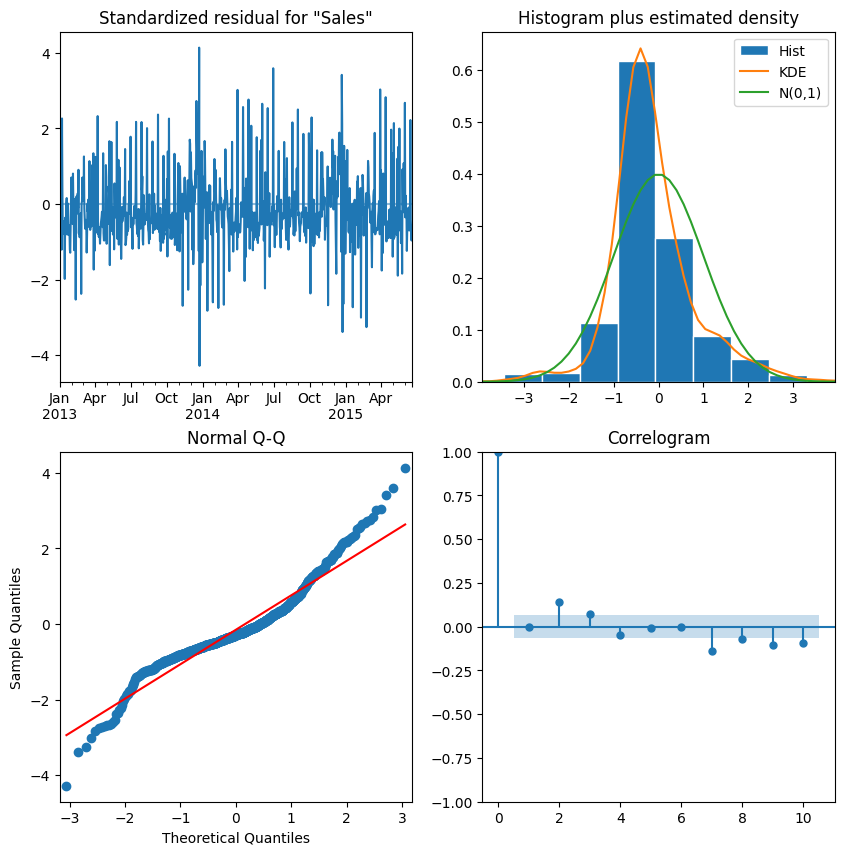

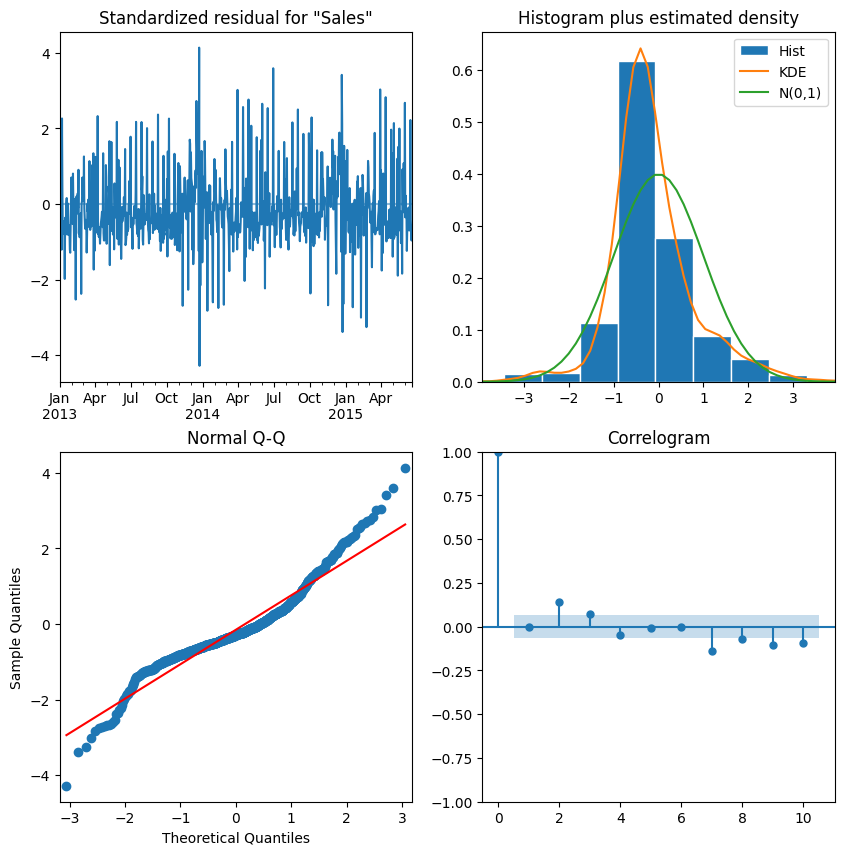

In [ ]:
res_VARMAX.plot_diagnostics(figsize=(10,10))

Residuals are showing a normal distribution around the mean which is very close to zero. Also there is no corellation between the residuals. We can say that model is almost well fitted.

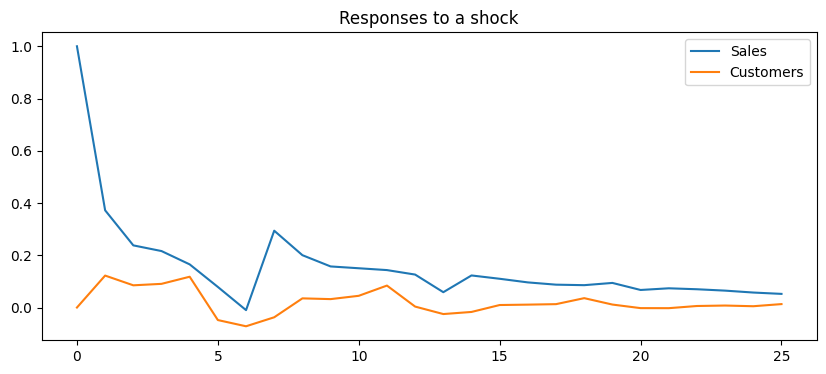

In [ ]:
# Impulse response factor

irf = res_VARMAX.impulse_responses(steps=25, orthogonalized=False)
irf.plot(figsize=(10,4),title='Responses to a shock')
plt.show()

A shock to the model can affect the Sales ,it become stable after continuously decreasing.On the other hand Customers count is constant.

In [ ]:
# Training the model

start_index = df_test_values.index.min()

end_index = df_test_values.index.max()



predictions = model_VARMAX.fit().predict(start = start_index, end = end_index,
                                         exog = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                                                                "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]])

In [ ]:
# Checking the shape of the predictions

predictions.shape

(42, 2)

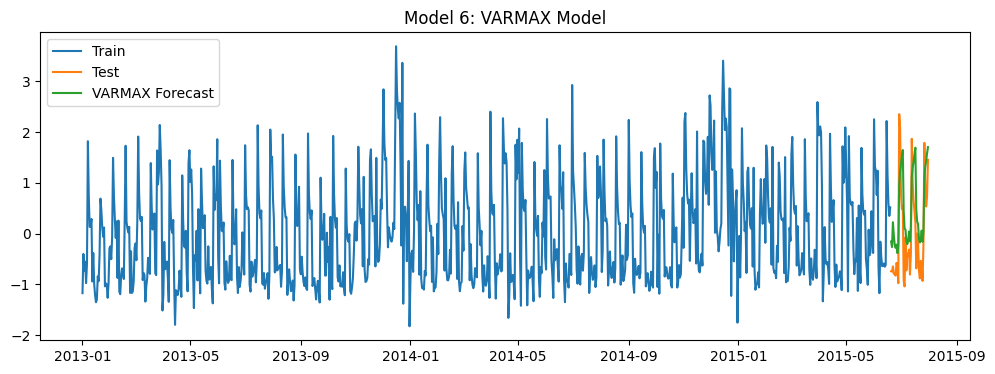

In [ ]:
# Plotting the Train, Test and VARMAX forecasts

plt.figure(figsize=(12,4))
plt.plot(df_train_values["Sales"], label="Train")
plt.plot(df_test_values["Sales"], label="Test")
plt.plot(predictions["Sales"], label="VARMAX Forecast")
plt.legend(loc="best")
plt.title("Model 6: VARMAX Model")
plt.show()

In [ ]:
# Calculating RMSE and Mape for Model 6: VARMAX Model

rmse = np.sqrt(mean_squared_error(df_test_values["Sales"], predictions["Sales"][df_test_values.index.min():])).round(2)
mape = np.round(np.mean(np.abs(df_test_values["Sales"]-predictions["Sales"][df_test_values.index.min():])/df_test_values["Sales"])*100,2)

tempResults = pd.DataFrame({"Method":["VARMAX Method"], "RMSE": [rmse],"MAPE": [mape] })
results = pd.concat([results, tempResults])
results = results[["Method", "RMSE", "MAPE"]]

# Displaying the "results" dataframe
results

Method  RMSE     MAPE
0      AR Method  1.71   973.12
0      MA Method  3.00  6834.44
0   ARIMA Method  1.84  1529.96
0  SARIMA Method  1.80  5485.74
0     VAR Method  0.41  2770.17
0  VARMAX Method  0.75   585.41

### Summary of all the models

In [ ]:
# Displaying the "results" dataframe soted by the "MAPE" column

results_sorted = results.sort_values(by=["MAPE"], ascending = True)

results_sorted

Method  RMSE     MAPE
0  VARMAX Method  0.75   585.41
0      AR Method  1.71   973.12
0   ARIMA Method  1.84  1529.96
0     VAR Method  0.41  2770.17
0  SARIMA Method  1.80  5485.74
0      MA Method  3.00  6834.44

**Conclusion**
- The VAR Method performs the best with the lowest RMSE and MAPE, meaning it provides the most accurate predictions.
- The VARMAX Method is second-best, with higher RMSE (761.88) and MAPE (7.14%) but still better than the others.
- Methods like SARIMA, ARIMA, and MA have much higher RMSE and MAPE values, indicating poor forecasting performance relative to VAR.

#### *Inference*:

- The best model is the <u> VAR (Vector Auto-Regressive) </u> model as it has the lowest values for RMSE and MAPE across all the models

- **`RMSE for VAR Model: 602.41`**

- **`MAPE for VAR Model: 6.18`**

In [ ]:
# Creating a function for visualization for the "Test" and "Forecasted" values using VAR Model

def forecast_series_visualize(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label="Actual")
    forecasted_series.plot(label="Forecasted")
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.legend(loc="best")
    plt.title("{} model For {}".format(model,c))
    plt.show()

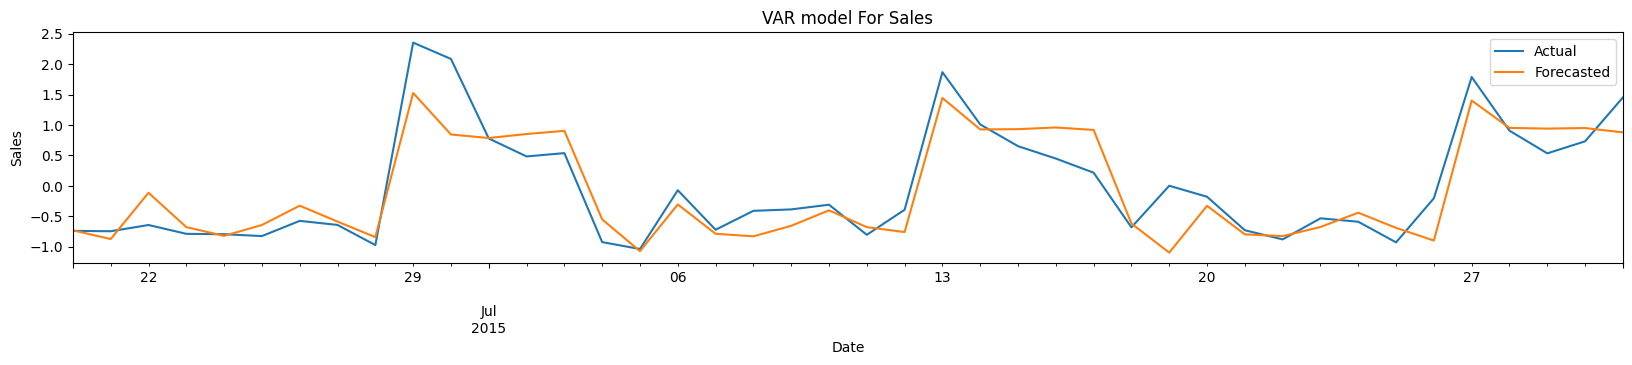

In [ ]:
# Plotting the forecasts of VAR Model:

forecast_series_visualize(df_test_values["Sales"], var_forecast["Sales"], "Sales", "VAR")

## Step 7: Predicting for the next 6 weeks (1st Aug 2015 to 11th September 2015)

In [ ]:
# Creating new dates from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

dates_range = pd.date_range(start="2015-08-01", end="2015-09-11")
new_dates = pd.DataFrame({"Date":dates_range, "Empty Column":np.nan})
new_dates = new_dates.set_index("Date")

In [ ]:
# Displaying "new_dates" dataframe

new_dates.head()

Empty Column
Date                    
2015-08-01           NaN
2015-08-02           NaN
2015-08-03           NaN
2015-08-04           NaN
2015-08-05           NaN

In [ ]:
# Checking the shape of the "new_dates" dataframe

new_dates.shape

(42, 1)

In [ ]:
# Selecting 042 as the length of our new "Train" dataset as we"re using the entire dataset as "Train" data

new_len_train = 942

df_newdates_train = df_train_data[:new_len_train]

In [ ]:
# Calculating values for model VAR

exog = df_newdates_train[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                          "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)
endog = df_newdates_train[["Sales", "Customers"]].astype(float)

var_new_model = sm.tsa.VAR(endog,exog)

res_new_var = var_new_model.select_order(maxlags=15)

print(res_new_var.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -4.620      -4.515    0.009857      -4.580
1       -4.881      -4.756    0.007590      -4.833
2       -4.880      -4.734    0.007601      -4.824
3       -4.897      -4.730    0.007473      -4.833
4       -4.904      -4.716    0.007418      -4.832
5       -4.951      -4.743    0.007073      -4.872
6       -5.056      -4.827    0.006370      -4.969
7       -5.073      -4.823    0.006261      -4.978
8       -5.090      -4.819    0.006157      -4.987
9       -5.133      -4.841    0.005899      -5.022
10      -5.224      -4.911    0.005389      -5.104
11      -5.310      -4.977    0.004941      -5.183
12      -5.331      -4.977    0.004839      -5.196
13      -5.349      -4.974    0.004753      -5.206
14      -5.384      -4.988    0.004589      -5.233
15     -5.429*     -5.012*   0.004389*     -5.270*
-------------------------------

**Conclusion:** A VAR model with a lag order of 15 is recommended as it minimizes all the selection criteria.
- AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), FPE (Final Prediction Error), and HQIC (Hannan-Quinn Information Criterion) are used to evaluate different lag orders.
- The lowest values in each column indicate the best model fit according to that criterion.
- For this data:
The minimum values for all criteria (AIC, BIC, FPE, HQIC) occur at lag 15.


In [ ]:
# Fitting the model and using Lag 15

var_new_modelfit = var_new_model.fit(15)

var_new_modelfit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Sep, 2024
Time:                     17:45:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.01178
Nobs:                     927.000    HQIC:                  -5.26971
Log likelihood:          -34.4744    FPE:                 0.00438893
AIC:                     -5.42878    Det(Omega_mle):      0.00403335
--------------------------------------------------------------------
Results for equation Sales
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.157620         2.118847            0.074           0.941
Promo                  0.001088         0.000067           16.170           0.000
Assortment_b          -3.858202         1.166664        

- Model Fit: The model has two equations, with a good fit as indicated by AIC (19.62) and BIC (20.04). High correlation between the residuals of Sales and Customers suggests strong interaction.

- Key Predictors for Sales:

-- Significant: Promo (positive), StateHoliday_a (negative), and lagged Sales & Customers at several periods (e.g., L1, L2, L10, L14, L15).
Not Significant: Assortment_c, StoreType_d.
Key Predictors for Customers:

-- Significant: Promo, StoreType_b (positive), StateHoliday_a (negative), and lagged Sales & Customers.
Not Significant: Assortment_c, StateHoliday_b.
Lag Impact: Lagged Sales and Customers variables up to 15 lags impact both Sales and Customers. Some lags are highly significant (e.g., L1, L2, L10, L14).

-- Overall: Promo and StateHoliday_a have the most consistent and significant effects across both Sales and Customers.

In [ ]:
# Taking the lag order from the model

lag_order = var_new_modelfit.k_ar

print(lag_order)

forecast_input = df_newdates_train[["Sales","Customers"]].values[-lag_order:]

forecast_input

15


array([[ 2.15296540e-01, -3.62747380e-01],
       [-6.82842838e-01, -9.45148629e-01],
       [ 9.40914475e-04,  1.11644637e+00],
       [-1.80148618e-01, -3.99221157e-01],
       [-7.30652157e-01, -7.67268813e-01],
       [-8.80983350e-01, -9.02069417e-01],
       [-5.34537162e-01, -6.58841028e-01],
       [-5.90676785e-01, -7.06683104e-01],
       [-9.29982572e-01, -1.19089388e+00],
       [-2.04599038e-01,  1.05220083e+00],
       [ 1.78784272e+00,  2.43018403e-01],
       [ 9.06251709e-01, -1.36720295e-01],
       [ 5.33405958e-01, -3.62495438e-01],
       [ 7.31162376e-01, -2.08033825e-01],
       [ 1.45273030e+00,  2.39932406e-01]])

In [ ]:
# Generating the forecasts

exog_test = df_test_values[["Promo", "Assortment_b", "Assortment_c", "StoreType_b","StoreType_c", "StoreType_d",
                            "StateHoliday_a","StateHoliday_b", "StateHoliday_c"]].astype(float)

new_week_forecasts = var_new_modelfit.forecast(y = forecast_input, steps = 42, exog_future = exog_test)
var_newweeks_forecast = pd.DataFrame(new_week_forecasts, index = new_dates.index, columns = ["Sales","Customers"])

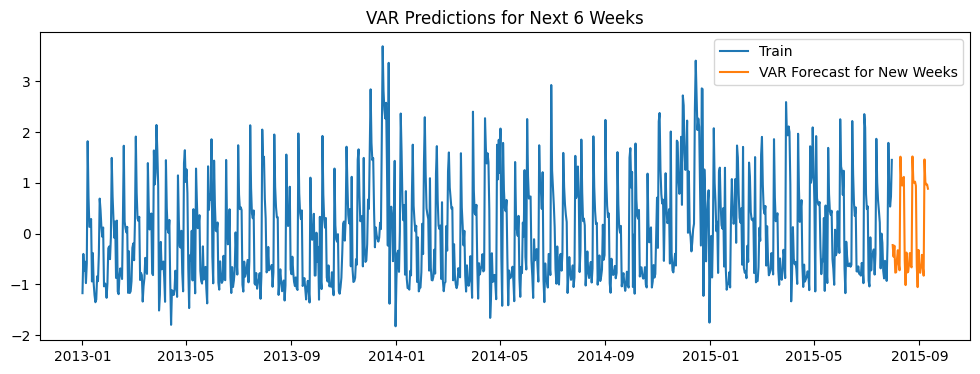

In [ ]:
# Plotting the Train and "var_newweeks_forecast"

plt.figure(figsize=(12,4))
plt.plot(df_newdates_train["Sales"], label="Train")
plt.plot(var_newweeks_forecast["Sales"][new_dates.index.min():], label="VAR Forecast for New Weeks")
plt.legend(loc="best")


plt.title("VAR Predictions for Next 6 Weeks")
plt.show()

In [ ]:
# Actual forecasts for the next 6 weeks from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

var_newweeks_forecast.head(10)

Sales  Customers
Date                           
2015-08-01 -0.223793  -0.576473
2015-08-02 -0.453468   0.809753
2015-08-03 -0.237481  -0.338975
2015-08-04 -0.766359  -0.697830
2015-08-05 -0.759960  -0.759089
2015-08-06 -0.501444  -0.563868
2015-08-07 -0.325715  -0.408995
2015-08-08 -0.591544  -0.781613
2015-08-09 -0.720737   0.439237
2015-08-10  1.515616   0.322983

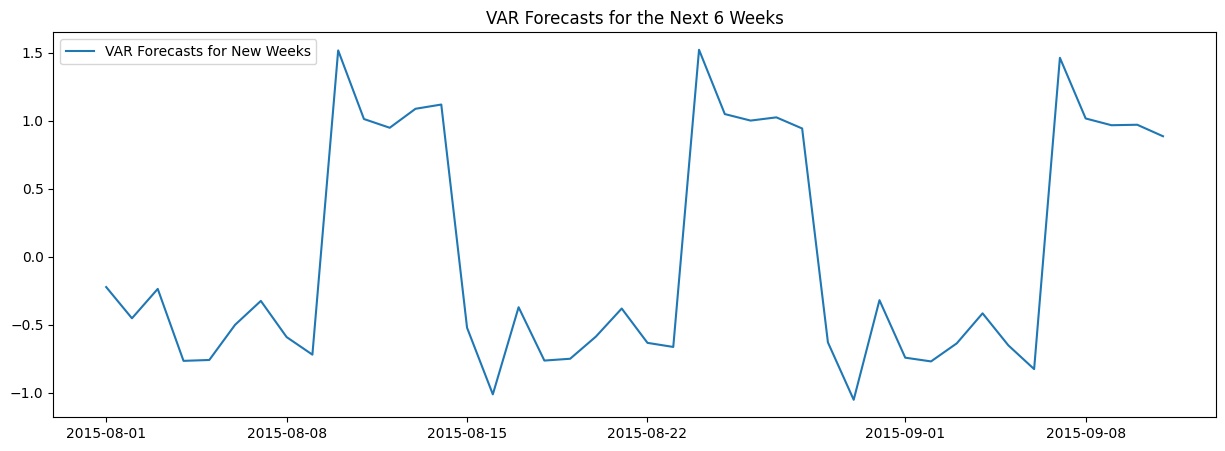

In [ ]:
# Plotting the predictions for the next 6 weeks from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks)

plt.figure(figsize=(15, 5))
plt.plot(var_newweeks_forecast["Sales"][new_dates.index.min():], label="VAR Forecasts for New Weeks")
plt.legend(loc="best")
plt.title("VAR Forecasts for the Next 6 Weeks")
plt.show()

## Step 8: Conclusion & Recommendations

### Conclusion

- We built multiple models like AR, MA, ARIMA, SARIMA, VAR and VARMAX

- The best model is the <u> VAR (Vector Auto-Regressive) </u> model as it has the lowest values for RMSE and MAPE across all the models

- **`RMSE for VAR Model: 602.41`**

- **`MAPE for VAR Model: 6.18`**

- We forecasted the "Sales" for the next 6 weeks from 1st Aug 2015 to 11th September 2015 (42 Days or 6 Weeks) using VAR model

- Promo: Significant positive effects on both Sales and Customers, as expected.
- Assortment: Different types of assortments (b and c) have varying effects. Assortment b has a negative effect on both Sales and Customers, while Assortment c has a positive effect.
- StoreType: Different store types (b, c, d) have significant positive effects on both Sales and Customers.

### Recommendations

- Increase the presence of store type "B" in the market as they demonstrate a higher percentage of sales compared to other store types
- Encourage the expansion of promotional activities across more stores
- Given seasonal trends, stores should capitalize on holidays by enhancing promotional efforts